## Real data

In [1]:
import sys
sys.path.insert(0,'..')

import training as tr
import emnet
import emsim_utils

import struct
import gc
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
#import scipy.optimize as optimize
from glob import glob

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [2]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=2):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('<H', chunk)[0]
            else:
                break    


# Read the specified number of images from the given file.
# Each "image" is the difference between two 512x512 "pre"-images
#  read in succession. Each image is median subtracted.
def read_images(datfile,nimages):
    
    # Create a reader.
    freader = iter(bytes_from_file(datfile))

    # Read 4-byte header.
    for i in range(2):
        next(freader)

    # Read the images.
    imgs = []
    for ni in range(nimages):

        img1 = []
        for i in range(512*512):
            img1.append(next(freader))

        img2 = []
        for i in range(512*512):
            img2.append(next(freader))

        imgs.append(np.array(img2).reshape([512,512]) - np.array(img1).reshape([512,512]))

    # Return the final image array in numpy format.
    imgs = np.array(imgs)
    imgs = imgs - np.median(imgs,axis=0)
    
    return imgs

#### Read the images

In [ ]:
th = 100
all_img_proc, all_img_th_proc = [], []
datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Average over all images to get the "processed" image.
    img_proc = np.average(imgs,axis=0)
    all_img_proc.append(img_proc)
    
    # Threshold the images to get individual counts.
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # Sum the thresholded images.
    img_th_proc = np.sum(imgs_th,axis=0)
    all_img_th_proc.append(img_th_proc)

all_img_proc = np.array(all_img_proc)
all_img_th_proc = np.array(all_img_th_proc)

In [ ]:
np.savez("aall_img_arrays.npz",all_img_proc=all_img_proc,all_img_th_proc=all_img_th_proc)

In [ ]:
# Load the arrays from the file
f_img_arrays = np.load("img_arrays_0_left.npz")
all_img_proc = f_img_arrays['all_img_proc']
all_img_th_proc = f_img_arrays['all_img_th_proc']

In [ ]:
fig, axs = plt.subplots(4, 8)
fig.set_figheight(8.0)
fig.set_figwidth(20.0)
for iplt in range(len(all_img_th_proc)):
    iaxis = int(iplt / 8)
    jaxis = iplt % 8
    axs[iaxis,jaxis].imshow(all_img_th_proc[iplt],vmax=100)

# plt.imshow(all_img_proc[11])
# plt.colorbar()

In [ ]:
# Create the summed, thresholded image from all datasets.
img_th_all = np.sum(all_img_th_proc,axis=0)
plt.imshow(img_th_all,vmax=1000)
plt.colorbar()

In [ ]:
# Check the numbers of counts in each pixel.
plt.hist(all_img_th_proc.flatten(),bins=100)
plt.yscale('log')

#### Histogram individual image elements to determine threshold

In [ ]:
# Create a histogram of all image elements.
plt.hist(imgs.flatten(),bins=100,range=[0,400])
plt.yscale("log")

In [ ]:
# Create a thresholded image.
th = 100
imgs_th = np.zeros(imgs.shape)
imgs_th[imgs > th] = 1#imgs[imgs > th]

In [ ]:
# Show the thresholded image.
img_th_proc = np.sum(imgs_th,axis=0)
plt.imshow(img_th_proc,vmax=10)
plt.colorbar()

#### Fit the edge of the thresholded image for each row

In [ ]:
def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

# Fit an s-curve to the specified row in img,
#  within a range of +/- rng centered upon x0.
def fit_scurve(img,nrow,x0,rng=50):
    
    # Choose the row, selecting elements (x0-rng):(x0+rng)
    xmin = max(0,x0-rng)
    xmax = min(img.shape[1],x0+rng)
    ydata = img[nrow,xmin:xmax]
    xdata = np.arange(xmin,xmax)

    # Set an initial guess and perform the fit.
    p0 = [np.mean(ydata[ydata > np.mean(ydata)]), x0, 1, min(ydata)]
    popt, pcov = curve_fit(sigmoid, xdata, ydata, p0, method='dogbox') #, bounds=((-max(ydata), x0-20, -np.inf, 0), (max(ydata), x0+20, np.inf, 200)))
    
    return popt

In [ ]:
x_guess = 357
x_edges = []
for row in range(img_th_all.shape[0]):
    
    # Perform the fit.
    try:
        L,x0,k,b = fit_scurve(img_th_all,row,x_guess)
    except:
        print("** Fit failed for row",row)
        L,k,b = None,None,None
        x0 = x_guess
    
    x_edge = int(np.round(x0))
    x_edges.append(x_edge)
    x_guess = x_edge
    print("-- Fit row",row,": L=",L,"x0=",x0,"k=",k,"b=",b)
x_edges = np.array(x_edges)

##### Plot the edge

In [ ]:
img_edge = np.zeros([512,512]) #img_th_all.shape)
for row,iedge in zip(range(img_edge.shape[0]),x_edges):
    img_edge[row,iedge] = 1

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.imshow(img_th_all,vmax=1000)
plt.colorbar()
#plt.imshow(img_edge,alpha=0.1)

ax2 = fig.add_subplot(122)
plt.imshow(img_edge)

##### Test a single fit

In [ ]:
row = 0
x_guess = 360
rng = 50

popt = fit_scurve(img_th_all,row,x_guess)

xmin = max(0,x_guess-rng)
xmax = min(img_th_all.shape[1],x_guess+rng)
ydata = img_th_all[row,xmin:xmax]
xdata = np.arange(xmin,xmax)

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
plt.xlabel("Image column")
plt.ylabel("Counts")

print("-- Fit row",row,": popt =",popt)
print(np.mean(ydata[ydata > np.mean(ydata)]))

In [ ]:
# Save all arrays.
np.savez("img_arrays_0_right.npz",all_img_proc=all_img_proc,all_img_th_proc=all_img_th_proc,x_edges=x_edges)

##### Select the images using the edge array

In [ ]:
f_img_arrays = np.load("img_arrays_0_left.npz")
x_edges = f_img_arrays['x_edges']
side = 1 # 0 = right, 1 = left

In [ ]:
# Determines whether the image is a valid event.
def check_subimage_th(subimg):
    valid = False
    
    # Ensure the maximum pixel index is within some number of pixels of the borders.
    pixel_padding = 1
    max_index = np.unravel_index(subimg.argmax(),subimg.shape)
    valid = (max_index[0] > pixel_padding) and (max_index[0] < subimg.shape[0]-pixel_padding-1) and (max_index[1] > pixel_padding) and (max_index[1] < subimg.shape[1]-pixel_padding-1)
    
    # Ensure there is at least 1 nonzero pixel.
    valid = valid and (len(subimg[subimg > 0]) > 0) 
    
    return valid

def choose_subimages(img, img_th, available_edges, debug=False):

    valid_subimages, valid_subimages_c, valid_subimages_th = [], [], []
    line_m, line_b = [], []

    # Loop until no available edges remain.
    done = (available_edges == -1).all()
    while(not done):

        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)

        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue

        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            
            done = (available_edges == -1).all()
            continue

        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):

            # Construct the subimage.
            xmid = x_edges[rmid]
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1

            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):

                # Create the subimage.
                subimg    = img[rstart:rend,cstart:cend]
                subimg_th = img_th[rstart:rend,cstart:cend]
                
                # Compute the boundaries for the subimage centered on the max pixel.
                arg_max = np.unravel_index(np.argmax(subimg),subimg.shape)
                delta = int((subimg.shape[0]-1)/2)  # the extent of the event from the center pixel
                ileft = rstart + (arg_max[0] - delta)
                jleft = cstart + (arg_max[1] - delta)
                iright = rend + (arg_max[0] - delta)
                jright = cend + (arg_max[1] - delta)

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):

                    # Compute the slopes and intercepts.
                    x1 = (x_edges[rstart] - cstart) + 0.5
                    x2 = (x_edges[rend] - cstart) + 0.5
                    if(x2 == x1): 
                        if(side == 0): x2 = x1-1
                        else: x2 = x1+1
                    y1 = 0.5
                    y2 = (rend - rstart) - 0.5
                    m = (y2 - y1) / (x2 - x1)
                    b = y2 - m*x2
                    if(debug): print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                    if(debug): print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                    
                    # Only save the subimage if the slope is negative for side = 0 or positive for side = 1.
                    # (Note, because y increases downward, the notion of "negative" and "positive" is flipped.)
                    if(debug): print("side = {}, m = {}".format(side,m))
                    if((side == 0 and m < 0) or (side == 1 and m > 0)):

                        # Save the subimage if the centered subimage is also valid.
                        if(ileft >= rmin and iright < rmax and jleft >= cmin and jright < cmax):
                            if(debug): print("Centered subimage is valid.")
                            subimg_c = img[ileft:iright,jleft:jright]
                            arg_max_c = np.unravel_index(np.argmax(subimg_c),subimg_c.shape)

                            # Don't save the image if the center pixel is no longer the maximum.
                            if(arg_max_c[0] == delta and arg_max_c[1] == delta):
                                if(debug): print("Center pixel is no longer maximum: ADDING IMAGE")
                                valid_subimages.append(subimg)
                                valid_subimages_c.append(subimg_c)
                                valid_subimages_th.append(subimg_th)
                                line_m.append(m)
                                line_b.append(b)

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.

            else:
                available_edges[rstart:rend] = -1

        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1

        # Set the terminating condition.
        done = (available_edges == -1).all()
        #if(debug): print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))
    
    # Return the arrays.
    valid_subimages = np.array(valid_subimages)
    valid_subimages_c = np.array(valid_subimages_c)
    valid_subimages_th = np.array(valid_subimages_th)
    line_m = np.array(line_m)
    line_b = np.array(line_b)
    
    return valid_subimages, valid_subimages_c, valid_subimages_th, line_m, line_b

In [ ]:
th = 100
subimg_halfsize = 5
rmin = 0
rmax = len(x_edges)
cmin = 0
cmax = len(x_edges) # assume image is square

valid_subimages, valid_subimages_c, valid_subimages_th = None, None, None
line_m, line_b = None, None

datfiles = glob("/home/jrenner/local/data/4dstem/scan_0000001768/*.dat")
for datfile in datfiles[0:10]:
    print("Reading datafile",datfile)
    
    # Read in all images from the data file.
    imgs = read_images(datfile,2048)
    
    # Threshold the images to get individual counts
    imgs_th = np.zeros(imgs.shape)
    imgs_th[imgs > th] = 1
    
    # Get all subimages from each image.
    for iimg in range(len(imgs)):
        if(iimg % 200 == 0): print("--> Processing image",iimg,"of",len(imgs))
        
        # Get this image and its thresholded version.
        img = imgs[iimg]
        img_th = imgs_th[iimg]
        
        # Create a new array of available edges.
        available_edges = np.ones(len(x_edges))
        
        # Get the subimages.
        t_valid_subimages, t_valid_subimages_c, t_valid_subimages_th, t_line_m, t_line_b = choose_subimages(img, img_th, available_edges, debug = False)
        
        if(valid_subimages is None): valid_subimages = t_valid_subimages
        else: valid_subimages = np.append(valid_subimages, t_valid_subimages, axis=0)
        if(valid_subimages_c is None): valid_subimages_c = t_valid_subimages_c
        else: valid_subimages_c = np.append(valid_subimages_c, t_valid_subimages_c, axis=0)
        if(valid_subimages_th is None): valid_subimages_th = t_valid_subimages_th
        else: valid_subimages_th = np.append(valid_subimages_th, t_valid_subimages_th, axis=0)
        if(line_m is None): line_m = t_line_m
        else: line_m = np.append(line_m, t_line_m, axis=0)
        if(line_b is None): line_b = t_line_b
        else: line_b = np.append(line_b, t_line_b, axis=0)
        
    del imgs
    del imgs_th
    gc.collect()

# Convert to numpy arrays.
# valid_subimages = np.array(valid_subimages)
# valid_subimages_th = np.array(valid_subimages_th)
# line_m = np.array(line_m)
# line_b = np.array(line_b)

In [ ]:
valid_subimages_c.shape

In [ ]:
line_m.shape

In [ ]:
np.savez("subimgs_170k_left.npz",valid_subimages=valid_subimages,valid_subimages_c=valid_subimages_c,valid_subimages_th=valid_subimages_th,line_m=line_m,line_b=line_b)

In [ ]:
# Load the subimages
fn = np.load("subimgs_173k_right.npz")
valid_subimages = fn['valid_subimages']
valid_subimages_c = fn['valid_subimages_c']
valid_subimages_th = fn['valid_subimages_th']
line_m = fn['line_m']
line_b = fn['line_b']

In [ ]:
isub = 15
nrows = ncols = 11

In [ ]:
# Plot subimages.
mm = line_m[isub]
bb = line_b[isub]
xfit = np.arange(0,ncols-1,1e-4)
yfit = mm*xfit + bb

plt.imshow(valid_subimages[isub])
plt.plot(xfit[(yfit >= 0) & (yfit < nrows-1)],yfit[(yfit >= 0) & (yfit < nrows-1)],linewidth=2,color='red')
print("Slope is",mm,"and intercept is",bb)

In [ ]:
plt.imshow(valid_subimages_th[isub])
#plt.imshow(np.sum(valid_subimages_th,axis=0))

In [ ]:
len(valid_subimages)

#### Train the NN

In [3]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 50    # Number of final epoch
model_load_checkpoint = "{}/model_init_0.pt".format(modeldir)

# Create the dataset.
dataset_train = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_170k_left.npz",
                                    "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_173k_right.npz",
                                    0,150000)
dataset_val = tr.RealFrameDataset("/home/jrenner/local/jerenner/emsim/notebooks/subimgs_170k_left.npz",
                                  "/home/jrenner/local/jerenner/emsim/notebooks/subimgs_173k_right.npz",
                                  150000,170000)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=False, collate_fn=tr.my_collate_reg_line_realdata, num_workers=1)

# Define the model.
model = emnet.basicCNN_reg()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
#optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    for m in model.modules():
        for child in m.children():
            if type(child) == nn.BatchNorm2d:
                child.track_running_stats = False
                child.running_mean = None
                child.running_var = None
    model.eval()

In [4]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_regression_line(model, epoch, train_loader, optimizer, 1000)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

Epoch:  0
Train Epoch: 0 [0/150000 (0%)]	Loss: 3.780251	 score_max: 2.395552	 score_min: -15.356049; Accuracy 0.017; LR 0.001
Not considering distance loss.
Train Epoch: 0 [1000/150000 (1%)]	Loss: 41.309568	 score_max: 58.388885	 score_min: -11.971028; Accuracy 0.008; LR 0.001
Not considering distance loss.


/home/jrenner/miniconda3/envs/tf2/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 0 [2000/150000 (1%)]	Loss: 3.955400	 score_max: 18.166933	 score_min: -4.163593; Accuracy 0.033; LR 0.001
Train Epoch: 0 [3000/150000 (2%)]	Loss: 6.021013	 score_max: 7.031327	 score_min: -17.692928; Accuracy 0.007; LR 0.001
Train Epoch: 0 [4000/150000 (3%)]	Loss: 2.347212	 score_max: 9.835985	 score_min: -14.019336; Accuracy 0.017; LR 0.001
Not considering distance loss.
Train Epoch: 0 [5000/150000 (3%)]	Loss: 1.435543	 score_max: 12.941441	 score_min: -7.502271; Accuracy 0.024; LR 0.001
Not considering distance loss.
Train Epoch: 0 [6000/150000 (4%)]	Loss: 1.716649	 score_max: 17.000755	 score_min: -3.613549; Accuracy 0.033; LR 0.001
Not considering distance loss.
Train Epoch: 0 [7000/150000 (5%)]	Loss: 1.843337	 score_max: 20.369890	 score_min: -9.777836; Accuracy 0.026; LR 0.001
Not considering distance loss.
Train Epoch: 0 [8000/150000 (5%)]	Loss: 1.268028	 score_max: 18.739100	 score_min: -8.982120; Accuracy 0.016; LR 0.001
Not considering distance loss.
Train Epoch:

Train Epoch: 0 [70000/150000 (47%)]	Loss: 1.334092	 score_max: 4.696511	 score_min: -9.617079; Accuracy 0.090; LR 0.001
Train Epoch: 0 [71000/150000 (47%)]	Loss: 1.413001	 score_max: 8.429296	 score_min: -7.153097; Accuracy 0.057; LR 0.001
Train Epoch: 0 [72000/150000 (48%)]	Loss: 1.134879	 score_max: 6.478709	 score_min: -5.294743; Accuracy 0.032; LR 0.001
Train Epoch: 0 [73000/150000 (49%)]	Loss: 1.455054	 score_max: 8.099741	 score_min: -5.954251; Accuracy 0.021; LR 0.001
Train Epoch: 0 [74000/150000 (49%)]	Loss: 1.294772	 score_max: 6.649508	 score_min: -5.834282; Accuracy 0.017; LR 0.001
Not considering distance loss.
Train Epoch: 0 [75000/150000 (50%)]	Loss: 0.783496	 score_max: 14.687075	 score_min: -4.509393; Accuracy 0.019; LR 0.001
Train Epoch: 0 [76000/150000 (51%)]	Loss: 1.707042	 score_max: 9.331206	 score_min: -4.488788; Accuracy 0.026; LR 0.001
Train Epoch: 0 [77000/150000 (51%)]	Loss: 1.328653	 score_max: 8.039493	 score_min: -8.285267; Accuracy 0.020; LR 0.001
Train Ep

Train Epoch: 0 [138000/150000 (92%)]	Loss: 1.128544	 score_max: 7.153187	 score_min: -5.251748; Accuracy 0.027; LR 0.001
Not considering distance loss.
Train Epoch: 0 [139000/150000 (93%)]	Loss: 0.378375	 score_max: 11.403899	 score_min: -2.166656; Accuracy 0.027; LR 0.001
Train Epoch: 0 [140000/150000 (93%)]	Loss: 1.095076	 score_max: 6.937896	 score_min: -4.414180; Accuracy 0.021; LR 0.001
Train Epoch: 0 [141000/150000 (94%)]	Loss: 1.145362	 score_max: 7.232137	 score_min: -4.017603; Accuracy 0.024; LR 0.001
Train Epoch: 0 [142000/150000 (95%)]	Loss: 1.048759	 score_max: 7.228240	 score_min: -3.329745; Accuracy 0.019; LR 0.001
Train Epoch: 0 [143000/150000 (95%)]	Loss: 1.057580	 score_max: 4.572839	 score_min: -4.593211; Accuracy 0.023; LR 0.001
Train Epoch: 0 [144000/150000 (96%)]	Loss: 1.197263	 score_max: 6.331956	 score_min: -5.987974; Accuracy 0.019; LR 0.001
Train Epoch: 0 [145000/150000 (97%)]	Loss: 1.033416	 score_max: 3.888382	 score_min: -4.873567; Accuracy 0.011; LR 0.001


Train Epoch: 1 [57000/150000 (38%)]	Loss: 1.089520	 score_max: 5.768347	 score_min: -3.621329; Accuracy 0.013; LR 0.001
Not considering distance loss.
Train Epoch: 1 [58000/150000 (39%)]	Loss: 0.322574	 score_max: 11.096416	 score_min: -5.848666; Accuracy 0.017; LR 0.001
Train Epoch: 1 [59000/150000 (39%)]	Loss: 1.047881	 score_max: 6.600394	 score_min: -4.871134; Accuracy 0.014; LR 0.001
Train Epoch: 1 [60000/150000 (40%)]	Loss: 1.230408	 score_max: 10.677625	 score_min: -4.433609; Accuracy 0.013; LR 0.001
Train Epoch: 1 [61000/150000 (41%)]	Loss: 1.232695	 score_max: 8.614590	 score_min: -4.047186; Accuracy 0.014; LR 0.001
Train Epoch: 1 [62000/150000 (41%)]	Loss: 1.172773	 score_max: 4.336604	 score_min: -8.971063; Accuracy 0.026; LR 0.001
Train Epoch: 1 [63000/150000 (42%)]	Loss: 0.965114	 score_max: 4.250219	 score_min: -4.682355; Accuracy 0.040; LR 0.001
Train Epoch: 1 [64000/150000 (43%)]	Loss: 1.124860	 score_max: 4.274867	 score_min: -6.731843; Accuracy 0.063; LR 0.001
Train E

Train Epoch: 1 [129000/150000 (86%)]	Loss: 1.402864	 score_max: 4.423840	 score_min: -7.277503; Accuracy 0.050; LR 0.001
Train Epoch: 1 [130000/150000 (87%)]	Loss: 1.414557	 score_max: 2.986378	 score_min: -9.531124; Accuracy 0.040; LR 0.001
Train Epoch: 1 [131000/150000 (87%)]	Loss: 1.667650	 score_max: 4.744733	 score_min: -11.643213; Accuracy 0.046; LR 0.001
Train Epoch: 1 [132000/150000 (88%)]	Loss: 1.126117	 score_max: 7.031991	 score_min: -3.038061; Accuracy 0.020; LR 0.001
Train Epoch: 1 [133000/150000 (89%)]	Loss: 1.416290	 score_max: 6.772673	 score_min: -1.199555; Accuracy 0.010; LR 0.001
Train Epoch: 1 [134000/150000 (89%)]	Loss: 2.195495	 score_max: 9.155210	 score_min: -3.643579; Accuracy 0.008; LR 0.001
Not considering distance loss.
Train Epoch: 1 [135000/150000 (90%)]	Loss: 0.468730	 score_max: 12.089863	 score_min: -5.467356; Accuracy 0.013; LR 0.001
Train Epoch: 1 [136000/150000 (91%)]	Loss: 1.115166	 score_max: 4.413374	 score_min: -5.056357; Accuracy 0.015; LR 0.001

Train Epoch: 2 [50000/150000 (33%)]	Loss: 0.932880	 score_max: 2.766907	 score_min: -3.195623; Accuracy 0.023; LR 0.001
Train Epoch: 2 [51000/150000 (34%)]	Loss: 0.804110	 score_max: 3.898074	 score_min: -2.312370; Accuracy 0.025; LR 0.001
Train Epoch: 2 [52000/150000 (35%)]	Loss: 0.972728	 score_max: 4.678617	 score_min: -3.603026; Accuracy 0.018; LR 0.001
Train Epoch: 2 [53000/150000 (35%)]	Loss: 1.092806	 score_max: 4.864583	 score_min: -4.589418; Accuracy 0.021; LR 0.001
Train Epoch: 2 [54000/150000 (36%)]	Loss: 1.081109	 score_max: 3.546297	 score_min: -3.506143; Accuracy 0.031; LR 0.001
Train Epoch: 2 [55000/150000 (37%)]	Loss: 0.965339	 score_max: 3.889043	 score_min: -2.234680; Accuracy 0.034; LR 0.001
Train Epoch: 2 [56000/150000 (37%)]	Loss: 0.971850	 score_max: 2.080102	 score_min: -2.716079; Accuracy 0.027; LR 0.001
Train Epoch: 2 [57000/150000 (38%)]	Loss: 0.913925	 score_max: 5.448417	 score_min: -4.347677; Accuracy 0.029; LR 0.001
Train Epoch: 2 [58000/150000 (39%)]	Loss

Train Epoch: 2 [123000/150000 (82%)]	Loss: 0.928959	 score_max: 2.623744	 score_min: -4.874225; Accuracy 0.034; LR 0.001
Train Epoch: 2 [124000/150000 (83%)]	Loss: 0.868991	 score_max: 2.930197	 score_min: -2.837144; Accuracy 0.043; LR 0.001
Train Epoch: 2 [125000/150000 (83%)]	Loss: 0.815994	 score_max: 4.012484	 score_min: -4.314141; Accuracy 0.047; LR 0.001
Train Epoch: 2 [126000/150000 (84%)]	Loss: 0.942532	 score_max: 3.435708	 score_min: -3.411707; Accuracy 0.057; LR 0.001
Train Epoch: 2 [127000/150000 (85%)]	Loss: 0.844280	 score_max: 3.492955	 score_min: -2.896849; Accuracy 0.040; LR 0.001
Train Epoch: 2 [128000/150000 (85%)]	Loss: 0.864055	 score_max: 2.696757	 score_min: -1.308795; Accuracy 0.038; LR 0.001
Train Epoch: 2 [129000/150000 (86%)]	Loss: 0.888963	 score_max: 3.912235	 score_min: -2.210671; Accuracy 0.062; LR 0.001
Train Epoch: 2 [130000/150000 (87%)]	Loss: 0.898968	 score_max: 3.741981	 score_min: -0.910892; Accuracy 0.059; LR 0.001
Train Epoch: 2 [131000/150000 (8

Train Epoch: 3 [43000/150000 (29%)]	Loss: 0.860975	 score_max: 4.410785	 score_min: -2.725582; Accuracy 0.049; LR 0.001
Train Epoch: 3 [44000/150000 (29%)]	Loss: 0.901305	 score_max: 3.283334	 score_min: -2.033993; Accuracy 0.042; LR 0.001
Train Epoch: 3 [45000/150000 (30%)]	Loss: 0.851715	 score_max: 2.189721	 score_min: -2.395483; Accuracy 0.041; LR 0.001
Train Epoch: 3 [46000/150000 (31%)]	Loss: 0.857544	 score_max: 3.352630	 score_min: -3.227140; Accuracy 0.062; LR 0.001
Train Epoch: 3 [47000/150000 (31%)]	Loss: 0.774631	 score_max: 1.669398	 score_min: -3.297482; Accuracy 0.047; LR 0.001
Train Epoch: 3 [48000/150000 (32%)]	Loss: 0.847370	 score_max: 1.663258	 score_min: -2.382528; Accuracy 0.069; LR 0.001
Train Epoch: 3 [49000/150000 (33%)]	Loss: 0.815919	 score_max: 2.301894	 score_min: -1.632366; Accuracy 0.069; LR 0.001
Train Epoch: 3 [50000/150000 (33%)]	Loss: 0.852979	 score_max: 2.021759	 score_min: -2.874996; Accuracy 0.056; LR 0.001
Train Epoch: 3 [51000/150000 (34%)]	Loss

Train Epoch: 3 [114000/150000 (76%)]	Loss: 0.937821	 score_max: 2.089650	 score_min: -3.161772; Accuracy 0.028; LR 0.001
Train Epoch: 3 [115000/150000 (77%)]	Loss: 0.833559	 score_max: 3.381643	 score_min: -1.750755; Accuracy 0.033; LR 0.001
Train Epoch: 3 [116000/150000 (77%)]	Loss: 0.986685	 score_max: 1.848902	 score_min: -2.304607; Accuracy 0.034; LR 0.001
Train Epoch: 3 [117000/150000 (78%)]	Loss: 0.913070	 score_max: 2.195061	 score_min: -1.807098; Accuracy 0.035; LR 0.001
Train Epoch: 3 [118000/150000 (79%)]	Loss: 0.837584	 score_max: 1.940225	 score_min: -1.713516; Accuracy 0.031; LR 0.001
Train Epoch: 3 [119000/150000 (79%)]	Loss: 0.797254	 score_max: 4.236274	 score_min: -1.680281; Accuracy 0.035; LR 0.001
Train Epoch: 3 [120000/150000 (80%)]	Loss: 0.840445	 score_max: 3.125566	 score_min: -1.458259; Accuracy 0.034; LR 0.001
Train Epoch: 3 [121000/150000 (81%)]	Loss: 0.867627	 score_max: 2.838271	 score_min: -1.158366; Accuracy 0.030; LR 0.001
Train Epoch: 3 [122000/150000 (8

Train Epoch: 4 [36000/150000 (24%)]	Loss: 0.918440	 score_max: 2.110024	 score_min: -1.043255; Accuracy 0.039; LR 0.001
Train Epoch: 4 [37000/150000 (25%)]	Loss: 0.845857	 score_max: 2.563527	 score_min: -3.277137; Accuracy 0.044; LR 0.001
Train Epoch: 4 [38000/150000 (25%)]	Loss: 0.803638	 score_max: 1.357143	 score_min: -1.208499; Accuracy 0.036; LR 0.001
Train Epoch: 4 [39000/150000 (26%)]	Loss: 0.913455	 score_max: 1.606264	 score_min: -1.386082; Accuracy 0.037; LR 0.001
Train Epoch: 4 [40000/150000 (27%)]	Loss: 0.957090	 score_max: 2.158903	 score_min: -2.508954; Accuracy 0.035; LR 0.001
Train Epoch: 4 [41000/150000 (27%)]	Loss: 0.763186	 score_max: 2.299233	 score_min: -1.334537; Accuracy 0.046; LR 0.001
Train Epoch: 4 [42000/150000 (28%)]	Loss: 0.815120	 score_max: 2.147312	 score_min: -2.133484; Accuracy 0.033; LR 0.001
Train Epoch: 4 [43000/150000 (29%)]	Loss: 0.953081	 score_max: 1.436913	 score_min: -1.682515; Accuracy 0.049; LR 0.001
Train Epoch: 4 [44000/150000 (29%)]	Loss

Train Epoch: 4 [109000/150000 (73%)]	Loss: 0.886622	 score_max: 2.152898	 score_min: -1.795990; Accuracy 0.020; LR 0.001
Train Epoch: 4 [110000/150000 (73%)]	Loss: 0.772014	 score_max: 2.597106	 score_min: -1.525496; Accuracy 0.028; LR 0.001
Train Epoch: 4 [111000/150000 (74%)]	Loss: 0.907965	 score_max: 1.935937	 score_min: -3.104539; Accuracy 0.023; LR 0.001
Train Epoch: 4 [112000/150000 (75%)]	Loss: 0.797528	 score_max: 1.798920	 score_min: -2.087223; Accuracy 0.029; LR 0.001
Train Epoch: 4 [113000/150000 (75%)]	Loss: 1.052711	 score_max: 2.337889	 score_min: -1.561970; Accuracy 0.012; LR 0.001
Train Epoch: 4 [114000/150000 (76%)]	Loss: 0.942919	 score_max: 1.130841	 score_min: -3.654717; Accuracy 0.018; LR 0.001
Train Epoch: 4 [115000/150000 (77%)]	Loss: 0.777276	 score_max: 1.457430	 score_min: -2.003402; Accuracy 0.020; LR 0.001
Train Epoch: 4 [116000/150000 (77%)]	Loss: 0.978085	 score_max: 2.218546	 score_min: -2.425408; Accuracy 0.015; LR 0.001
Train Epoch: 4 [117000/150000 (7

Train Epoch: 5 [29000/150000 (19%)]	Loss: 0.834285	 score_max: 1.293662	 score_min: -3.095514; Accuracy 0.027; LR 0.001
Train Epoch: 5 [30000/150000 (20%)]	Loss: 0.926890	 score_max: 1.449511	 score_min: -1.631919; Accuracy 0.030; LR 0.001
Train Epoch: 5 [31000/150000 (21%)]	Loss: 0.860344	 score_max: 2.224921	 score_min: -1.652994; Accuracy 0.031; LR 0.001
Train Epoch: 5 [32000/150000 (21%)]	Loss: 0.839422	 score_max: 2.003061	 score_min: -1.251486; Accuracy 0.050; LR 0.001
Train Epoch: 5 [33000/150000 (22%)]	Loss: 0.885071	 score_max: 2.924047	 score_min: -1.411016; Accuracy 0.041; LR 0.001
Train Epoch: 5 [34000/150000 (23%)]	Loss: 0.832225	 score_max: 2.233183	 score_min: -1.491680; Accuracy 0.033; LR 0.001
Train Epoch: 5 [35000/150000 (23%)]	Loss: 0.773012	 score_max: 1.708305	 score_min: -1.223371; Accuracy 0.046; LR 0.001
Train Epoch: 5 [36000/150000 (24%)]	Loss: 0.938385	 score_max: 2.546685	 score_min: -1.699864; Accuracy 0.036; LR 0.001
Train Epoch: 5 [37000/150000 (25%)]	Loss

Train Epoch: 5 [102000/150000 (68%)]	Loss: 0.980280	 score_max: 1.873830	 score_min: -1.437811; Accuracy 0.011; LR 0.001
Train Epoch: 5 [103000/150000 (69%)]	Loss: 0.782445	 score_max: 1.726120	 score_min: -2.201509; Accuracy 0.011; LR 0.001
Train Epoch: 5 [104000/150000 (69%)]	Loss: 0.837363	 score_max: 1.524948	 score_min: -1.586871; Accuracy 0.006; LR 0.001
Train Epoch: 5 [105000/150000 (70%)]	Loss: 0.964078	 score_max: 2.739131	 score_min: -1.807668; Accuracy 0.005; LR 0.001
Train Epoch: 5 [106000/150000 (71%)]	Loss: 0.798116	 score_max: 1.867617	 score_min: -1.664061; Accuracy 0.009; LR 0.001
Train Epoch: 5 [107000/150000 (71%)]	Loss: 0.933155	 score_max: 1.736250	 score_min: -1.261877; Accuracy 0.013; LR 0.001
Train Epoch: 5 [108000/150000 (72%)]	Loss: 0.769479	 score_max: 1.740514	 score_min: -1.097170; Accuracy 0.004; LR 0.001
Train Epoch: 5 [109000/150000 (73%)]	Loss: 0.880086	 score_max: 2.347254	 score_min: -1.019108; Accuracy 0.012; LR 0.001
Train Epoch: 5 [110000/150000 (7

Train Epoch: 6 [22000/150000 (15%)]	Loss: 0.804198	 score_max: 2.945661	 score_min: -2.475469; Accuracy 0.023; LR 0.001
Train Epoch: 6 [23000/150000 (15%)]	Loss: 0.894706	 score_max: 2.251287	 score_min: -1.258943; Accuracy 0.034; LR 0.001
Train Epoch: 6 [24000/150000 (16%)]	Loss: 0.894645	 score_max: 3.836199	 score_min: -1.069784; Accuracy 0.030; LR 0.001
Train Epoch: 6 [25000/150000 (17%)]	Loss: 0.864057	 score_max: 2.281639	 score_min: -1.347487; Accuracy 0.029; LR 0.001
Train Epoch: 6 [26000/150000 (17%)]	Loss: 0.851285	 score_max: 1.304857	 score_min: -1.646965; Accuracy 0.028; LR 0.001
Train Epoch: 6 [27000/150000 (18%)]	Loss: 0.802995	 score_max: 1.175237	 score_min: -2.391718; Accuracy 0.039; LR 0.001
Train Epoch: 6 [28000/150000 (19%)]	Loss: 0.793130	 score_max: 1.094870	 score_min: -2.413598; Accuracy 0.046; LR 0.001
Train Epoch: 6 [29000/150000 (19%)]	Loss: 0.840943	 score_max: 1.240709	 score_min: -1.911892; Accuracy 0.030; LR 0.001
Train Epoch: 6 [30000/150000 (20%)]	Loss

Train Epoch: 6 [97000/150000 (65%)]	Loss: 0.860665	 score_max: 1.933713	 score_min: -1.884382; Accuracy 0.028; LR 0.001
Train Epoch: 6 [98000/150000 (65%)]	Loss: 1.035373	 score_max: 2.801486	 score_min: -1.458428; Accuracy 0.021; LR 0.001
Train Epoch: 6 [99000/150000 (66%)]	Loss: 0.908482	 score_max: 1.961864	 score_min: -1.518412; Accuracy 0.017; LR 0.001
Train Epoch: 6 [100000/150000 (67%)]	Loss: 0.790077	 score_max: 1.594894	 score_min: -1.388645; Accuracy 0.021; LR 0.001
Train Epoch: 6 [101000/150000 (67%)]	Loss: 0.807267	 score_max: 1.530136	 score_min: -1.374820; Accuracy 0.019; LR 0.001
Train Epoch: 6 [102000/150000 (68%)]	Loss: 0.956727	 score_max: 1.422566	 score_min: -2.127977; Accuracy 0.019; LR 0.001
Train Epoch: 6 [103000/150000 (69%)]	Loss: 0.755472	 score_max: 1.609538	 score_min: -0.944777; Accuracy 0.026; LR 0.001
Train Epoch: 6 [104000/150000 (69%)]	Loss: 0.744020	 score_max: 1.300812	 score_min: -1.156669; Accuracy 0.025; LR 0.001
Train Epoch: 6 [105000/150000 (70%)

Train Epoch: 7 [14000/150000 (9%)]	Loss: 0.830263	 score_max: 1.273491	 score_min: -2.714384; Accuracy 0.027; LR 0.001
Train Epoch: 7 [15000/150000 (10%)]	Loss: 0.739476	 score_max: 1.495377	 score_min: -1.418533; Accuracy 0.022; LR 0.001
Train Epoch: 7 [16000/150000 (11%)]	Loss: 0.765181	 score_max: 1.495004	 score_min: -1.793864; Accuracy 0.027; LR 0.001
Train Epoch: 7 [17000/150000 (11%)]	Loss: 0.882404	 score_max: 1.390824	 score_min: -2.599299; Accuracy 0.023; LR 0.001
Train Epoch: 7 [18000/150000 (12%)]	Loss: 0.790302	 score_max: 1.619965	 score_min: -2.005160; Accuracy 0.035; LR 0.001
Train Epoch: 7 [19000/150000 (13%)]	Loss: 0.879956	 score_max: 1.385766	 score_min: -1.813271; Accuracy 0.028; LR 0.001
Train Epoch: 7 [20000/150000 (13%)]	Loss: 0.848513	 score_max: 1.226367	 score_min: -1.150769; Accuracy 0.040; LR 0.001
Train Epoch: 7 [21000/150000 (14%)]	Loss: 0.770324	 score_max: 1.271111	 score_min: -1.546348; Accuracy 0.029; LR 0.001
Train Epoch: 7 [22000/150000 (15%)]	Loss:

Train Epoch: 7 [85000/150000 (57%)]	Loss: 0.757366	 score_max: 1.197271	 score_min: -1.603602; Accuracy 0.059; LR 0.001
Train Epoch: 7 [86000/150000 (57%)]	Loss: 0.785989	 score_max: 1.399741	 score_min: -1.246769; Accuracy 0.046; LR 0.001
Train Epoch: 7 [87000/150000 (58%)]	Loss: 0.828626	 score_max: 1.241746	 score_min: -1.253667; Accuracy 0.050; LR 0.001
Train Epoch: 7 [88000/150000 (59%)]	Loss: 0.893661	 score_max: 1.401808	 score_min: -1.657593; Accuracy 0.045; LR 0.001
Train Epoch: 7 [89000/150000 (59%)]	Loss: 0.836650	 score_max: 1.115196	 score_min: -1.209873; Accuracy 0.046; LR 0.001
Train Epoch: 7 [90000/150000 (60%)]	Loss: 0.821179	 score_max: 1.351344	 score_min: -0.799754; Accuracy 0.047; LR 0.001
Train Epoch: 7 [91000/150000 (61%)]	Loss: 0.849556	 score_max: 1.665333	 score_min: -1.046773; Accuracy 0.040; LR 0.001
Train Epoch: 7 [92000/150000 (61%)]	Loss: 0.780595	 score_max: 1.280667	 score_min: -1.080349; Accuracy 0.043; LR 0.001
Train Epoch: 7 [93000/150000 (62%)]	Loss

Train Epoch: 8 [7000/150000 (5%)]	Loss: 0.883899	 score_max: 1.975740	 score_min: -1.143638; Accuracy 0.028; LR 0.001
Train Epoch: 8 [8000/150000 (5%)]	Loss: 0.809942	 score_max: 1.398515	 score_min: -1.512078; Accuracy 0.022; LR 0.001
Train Epoch: 8 [9000/150000 (6%)]	Loss: 0.946169	 score_max: 1.782254	 score_min: -1.784360; Accuracy 0.029; LR 0.001
Train Epoch: 8 [10000/150000 (7%)]	Loss: 0.667219	 score_max: 2.013625	 score_min: -1.509432; Accuracy 0.021; LR 0.001
Train Epoch: 8 [11000/150000 (7%)]	Loss: 0.949814	 score_max: 1.898904	 score_min: -1.217140; Accuracy 0.034; LR 0.001
Train Epoch: 8 [12000/150000 (8%)]	Loss: 0.908015	 score_max: 1.566532	 score_min: -1.132380; Accuracy 0.034; LR 0.001
Train Epoch: 8 [13000/150000 (9%)]	Loss: 0.724767	 score_max: 1.536409	 score_min: -1.748130; Accuracy 0.033; LR 0.001
Train Epoch: 8 [14000/150000 (9%)]	Loss: 0.818093	 score_max: 1.479211	 score_min: -1.433855; Accuracy 0.030; LR 0.001
Train Epoch: 8 [15000/150000 (10%)]	Loss: 0.772489	

Train Epoch: 8 [81000/150000 (54%)]	Loss: 0.858867	 score_max: 1.087263	 score_min: -1.817276; Accuracy 0.035; LR 0.001
Train Epoch: 8 [82000/150000 (55%)]	Loss: 0.850114	 score_max: 1.450992	 score_min: -1.614130; Accuracy 0.031; LR 0.001
Train Epoch: 8 [83000/150000 (55%)]	Loss: 0.832691	 score_max: 1.346507	 score_min: -1.509591; Accuracy 0.029; LR 0.001
Train Epoch: 8 [84000/150000 (56%)]	Loss: 0.870001	 score_max: 1.086135	 score_min: -1.258659; Accuracy 0.047; LR 0.001
Train Epoch: 8 [85000/150000 (57%)]	Loss: 0.756711	 score_max: 1.219860	 score_min: -2.690856; Accuracy 0.038; LR 0.001
Train Epoch: 8 [86000/150000 (57%)]	Loss: 0.818751	 score_max: 1.094498	 score_min: -1.216966; Accuracy 0.025; LR 0.001
Train Epoch: 8 [87000/150000 (58%)]	Loss: 0.889372	 score_max: 1.600564	 score_min: -1.055947; Accuracy 0.020; LR 0.001
Train Epoch: 8 [88000/150000 (59%)]	Loss: 0.885816	 score_max: 1.432036	 score_min: -1.071497; Accuracy 0.032; LR 0.001
Train Epoch: 8 [89000/150000 (59%)]	Loss

Train Epoch: 9 [0/150000 (0%)]	Loss: 0.867300	 score_max: 1.692162	 score_min: -2.972984; Accuracy 0.037; LR 0.001
Train Epoch: 9 [1000/150000 (1%)]	Loss: 0.746773	 score_max: 1.206978	 score_min: -1.510337; Accuracy 0.035; LR 0.001
Train Epoch: 9 [2000/150000 (1%)]	Loss: 0.825507	 score_max: 2.163476	 score_min: -1.169621; Accuracy 0.030; LR 0.001
Train Epoch: 9 [3000/150000 (2%)]	Loss: 0.803269	 score_max: 1.711370	 score_min: -2.010303; Accuracy 0.039; LR 0.001
Train Epoch: 9 [4000/150000 (3%)]	Loss: 0.871330	 score_max: 2.257167	 score_min: -1.428732; Accuracy 0.029; LR 0.001
Train Epoch: 9 [5000/150000 (3%)]	Loss: 0.947728	 score_max: 2.159117	 score_min: -1.251390; Accuracy 0.034; LR 0.001
Train Epoch: 9 [6000/150000 (4%)]	Loss: 0.828389	 score_max: 1.773647	 score_min: -1.868224; Accuracy 0.032; LR 0.001
Train Epoch: 9 [7000/150000 (5%)]	Loss: 0.776638	 score_max: 1.607191	 score_min: -1.212945; Accuracy 0.030; LR 0.001
Train Epoch: 9 [8000/150000 (5%)]	Loss: 0.886868	 score_max

Train Epoch: 9 [71000/150000 (47%)]	Loss: 0.771449	 score_max: 1.491350	 score_min: -1.495764; Accuracy 0.039; LR 0.001
Train Epoch: 9 [72000/150000 (48%)]	Loss: 0.835475	 score_max: 1.964717	 score_min: -1.519671; Accuracy 0.046; LR 0.001
Train Epoch: 9 [73000/150000 (49%)]	Loss: 0.801893	 score_max: 1.561473	 score_min: -1.468057; Accuracy 0.051; LR 0.001
Train Epoch: 9 [74000/150000 (49%)]	Loss: 0.934695	 score_max: 1.719581	 score_min: -1.475310; Accuracy 0.033; LR 0.001
Train Epoch: 9 [75000/150000 (50%)]	Loss: 0.772789	 score_max: 1.459117	 score_min: -1.374418; Accuracy 0.047; LR 0.001
Train Epoch: 9 [76000/150000 (51%)]	Loss: 0.824982	 score_max: 2.423314	 score_min: -1.794564; Accuracy 0.041; LR 0.001
Train Epoch: 9 [77000/150000 (51%)]	Loss: 0.872412	 score_max: 1.531059	 score_min: -1.525111; Accuracy 0.053; LR 0.001
Train Epoch: 9 [78000/150000 (52%)]	Loss: 0.904737	 score_max: 1.433636	 score_min: -1.238000; Accuracy 0.032; LR 0.001
Train Epoch: 9 [79000/150000 (53%)]	Loss

Train Epoch: 9 [143000/150000 (95%)]	Loss: 0.925987	 score_max: 1.436524	 score_min: -1.652576; Accuracy 0.038; LR 0.001
Train Epoch: 9 [144000/150000 (96%)]	Loss: 0.850992	 score_max: 1.442986	 score_min: -1.211400; Accuracy 0.045; LR 0.001
Train Epoch: 9 [145000/150000 (97%)]	Loss: 0.880311	 score_max: 1.186800	 score_min: -1.367671; Accuracy 0.035; LR 0.001
Train Epoch: 9 [146000/150000 (97%)]	Loss: 0.832529	 score_max: 1.266160	 score_min: -1.403200; Accuracy 0.055; LR 0.001
Train Epoch: 9 [147000/150000 (98%)]	Loss: 0.760735	 score_max: 2.619779	 score_min: -1.234960; Accuracy 0.050; LR 0.001
Train Epoch: 9 [148000/150000 (99%)]	Loss: 0.741520	 score_max: 1.529511	 score_min: -1.360257; Accuracy 0.056; LR 0.001
Train Epoch: 9 [149000/150000 (99%)]	Loss: 0.881383	 score_max: 2.003161	 score_min: -1.402410; Accuracy 0.055; LR 0.001
---EPOCH AVG TRAIN LOSS: 0.8356303156398138 (VEC: 0.006093668240547204 , DIST: 0.8295366473992666 ) ACCURACY: 0.029586667865514754
Epoch:  10
Train Epoch

Train Epoch: 10 [60000/150000 (40%)]	Loss: 0.928893	 score_max: 2.267794	 score_min: -1.270037; Accuracy 0.029; LR 0.001
Train Epoch: 10 [61000/150000 (41%)]	Loss: 0.753332	 score_max: 1.340496	 score_min: -1.191794; Accuracy 0.032; LR 0.001
Train Epoch: 10 [62000/150000 (41%)]	Loss: 0.783661	 score_max: 1.292171	 score_min: -2.050053; Accuracy 0.043; LR 0.001
Train Epoch: 10 [63000/150000 (42%)]	Loss: 0.862783	 score_max: 1.311155	 score_min: -1.419464; Accuracy 0.028; LR 0.001
Train Epoch: 10 [64000/150000 (43%)]	Loss: 0.834635	 score_max: 1.275183	 score_min: -1.779300; Accuracy 0.044; LR 0.001
Train Epoch: 10 [65000/150000 (43%)]	Loss: 0.798638	 score_max: 1.266421	 score_min: -1.382563; Accuracy 0.045; LR 0.001
Train Epoch: 10 [66000/150000 (44%)]	Loss: 0.830298	 score_max: 1.560273	 score_min: -1.156884; Accuracy 0.046; LR 0.001
Train Epoch: 10 [67000/150000 (45%)]	Loss: 0.836815	 score_max: 1.336501	 score_min: -1.607543; Accuracy 0.043; LR 0.001
Train Epoch: 10 [68000/150000 (4

Train Epoch: 10 [130000/150000 (87%)]	Loss: 0.815601	 score_max: 1.709765	 score_min: -1.417109; Accuracy 0.028; LR 0.001
Train Epoch: 10 [131000/150000 (87%)]	Loss: 0.884008	 score_max: 1.434948	 score_min: -1.578054; Accuracy 0.035; LR 0.001
Train Epoch: 10 [132000/150000 (88%)]	Loss: 0.748482	 score_max: 1.348572	 score_min: -2.020767; Accuracy 0.038; LR 0.001
Train Epoch: 10 [133000/150000 (89%)]	Loss: 0.784335	 score_max: 1.239561	 score_min: -1.836777; Accuracy 0.032; LR 0.001
Train Epoch: 10 [134000/150000 (89%)]	Loss: 0.867606	 score_max: 1.269713	 score_min: -1.622323; Accuracy 0.028; LR 0.001
Train Epoch: 10 [135000/150000 (90%)]	Loss: 0.803654	 score_max: 1.475727	 score_min: -1.290871; Accuracy 0.025; LR 0.001
Train Epoch: 10 [136000/150000 (91%)]	Loss: 0.929984	 score_max: 1.327172	 score_min: -1.205109; Accuracy 0.022; LR 0.001
Train Epoch: 10 [137000/150000 (91%)]	Loss: 0.798685	 score_max: 1.175908	 score_min: -0.983108; Accuracy 0.023; LR 0.001
Train Epoch: 10 [138000/

Train Epoch: 11 [50000/150000 (33%)]	Loss: 0.835665	 score_max: 1.781693	 score_min: -1.612315; Accuracy 0.029; LR 0.001
Train Epoch: 11 [51000/150000 (34%)]	Loss: 0.777845	 score_max: 1.465386	 score_min: -1.481380; Accuracy 0.032; LR 0.001
Train Epoch: 11 [52000/150000 (35%)]	Loss: 0.792836	 score_max: 1.278626	 score_min: -1.196703; Accuracy 0.047; LR 0.001
Train Epoch: 11 [53000/150000 (35%)]	Loss: 0.827087	 score_max: 1.729537	 score_min: -1.447890; Accuracy 0.048; LR 0.001
Train Epoch: 11 [54000/150000 (36%)]	Loss: 0.891559	 score_max: 1.118905	 score_min: -1.545260; Accuracy 0.033; LR 0.001
Train Epoch: 11 [55000/150000 (37%)]	Loss: 0.919467	 score_max: 1.592392	 score_min: -1.476472; Accuracy 0.036; LR 0.001
Train Epoch: 11 [56000/150000 (37%)]	Loss: 0.966442	 score_max: 1.832067	 score_min: -1.723488; Accuracy 0.019; LR 0.001
Train Epoch: 11 [57000/150000 (38%)]	Loss: 0.811609	 score_max: 1.988067	 score_min: -1.861968; Accuracy 0.025; LR 0.001
Train Epoch: 11 [58000/150000 (3

Train Epoch: 11 [123000/150000 (82%)]	Loss: 0.808958	 score_max: 1.366441	 score_min: -1.246133; Accuracy 0.018; LR 0.001
Train Epoch: 11 [124000/150000 (83%)]	Loss: 0.733273	 score_max: 1.246407	 score_min: -1.381515; Accuracy 0.020; LR 0.001
Train Epoch: 11 [125000/150000 (83%)]	Loss: 0.782798	 score_max: 1.194279	 score_min: -1.510881; Accuracy 0.016; LR 0.001
Train Epoch: 11 [126000/150000 (84%)]	Loss: 0.932516	 score_max: 1.189994	 score_min: -1.941802; Accuracy 0.033; LR 0.001
Train Epoch: 11 [127000/150000 (85%)]	Loss: 0.758430	 score_max: 1.143275	 score_min: -1.345177; Accuracy 0.028; LR 0.001
Train Epoch: 11 [128000/150000 (85%)]	Loss: 0.749334	 score_max: 1.279458	 score_min: -1.387869; Accuracy 0.043; LR 0.001
Train Epoch: 11 [129000/150000 (86%)]	Loss: 0.886531	 score_max: 1.711420	 score_min: -1.781309; Accuracy 0.041; LR 0.001
Train Epoch: 11 [130000/150000 (87%)]	Loss: 0.817368	 score_max: 1.215557	 score_min: -1.288099; Accuracy 0.047; LR 0.001
Train Epoch: 11 [131000/

Train Epoch: 12 [45000/150000 (30%)]	Loss: 0.778269	 score_max: 1.360690	 score_min: -1.667405; Accuracy 0.032; LR 0.001
Train Epoch: 12 [46000/150000 (31%)]	Loss: 0.960228	 score_max: 1.994645	 score_min: -1.669798; Accuracy 0.032; LR 0.001
Train Epoch: 12 [47000/150000 (31%)]	Loss: 0.715067	 score_max: 1.754756	 score_min: -1.269422; Accuracy 0.039; LR 0.001
Train Epoch: 12 [48000/150000 (32%)]	Loss: 0.805925	 score_max: 1.766514	 score_min: -1.509152; Accuracy 0.036; LR 0.001
Train Epoch: 12 [49000/150000 (33%)]	Loss: 0.809417	 score_max: 1.779857	 score_min: -1.574660; Accuracy 0.023; LR 0.001
Train Epoch: 12 [50000/150000 (33%)]	Loss: 0.803561	 score_max: 2.207711	 score_min: -1.832827; Accuracy 0.040; LR 0.001
Train Epoch: 12 [51000/150000 (34%)]	Loss: 0.762826	 score_max: 1.195940	 score_min: -1.274997; Accuracy 0.055; LR 0.001
Train Epoch: 12 [52000/150000 (35%)]	Loss: 0.782184	 score_max: 1.350975	 score_min: -1.893844; Accuracy 0.043; LR 0.001
Train Epoch: 12 [53000/150000 (3

Train Epoch: 12 [113000/150000 (75%)]	Loss: 0.991619	 score_max: 2.062162	 score_min: -1.714374; Accuracy 0.028; LR 0.001
Train Epoch: 12 [114000/150000 (76%)]	Loss: 0.792636	 score_max: 1.438870	 score_min: -1.202050; Accuracy 0.038; LR 0.001
Train Epoch: 12 [115000/150000 (77%)]	Loss: 0.830401	 score_max: 1.303226	 score_min: -1.449791; Accuracy 0.035; LR 0.001
Train Epoch: 12 [116000/150000 (77%)]	Loss: 0.842052	 score_max: 1.421620	 score_min: -1.177417; Accuracy 0.027; LR 0.001
Train Epoch: 12 [117000/150000 (78%)]	Loss: 0.784134	 score_max: 1.652322	 score_min: -1.376786; Accuracy 0.033; LR 0.001
Train Epoch: 12 [118000/150000 (79%)]	Loss: 0.869381	 score_max: 1.290078	 score_min: -1.174175; Accuracy 0.021; LR 0.001
Train Epoch: 12 [119000/150000 (79%)]	Loss: 0.828831	 score_max: 1.671320	 score_min: -2.184170; Accuracy 0.025; LR 0.001
Train Epoch: 12 [120000/150000 (80%)]	Loss: 0.733504	 score_max: 1.514492	 score_min: -1.931197; Accuracy 0.026; LR 0.001
Train Epoch: 12 [121000/

Train Epoch: 13 [36000/150000 (24%)]	Loss: 0.780736	 score_max: 1.238058	 score_min: -1.262889; Accuracy 0.047; LR 0.001
Train Epoch: 13 [37000/150000 (25%)]	Loss: 0.806431	 score_max: 1.363854	 score_min: -1.668865; Accuracy 0.047; LR 0.001
Train Epoch: 13 [38000/150000 (25%)]	Loss: 0.837214	 score_max: 1.653679	 score_min: -1.526535; Accuracy 0.051; LR 0.001
Train Epoch: 13 [39000/150000 (26%)]	Loss: 0.790442	 score_max: 1.147268	 score_min: -1.342113; Accuracy 0.059; LR 0.001
Train Epoch: 13 [40000/150000 (27%)]	Loss: 0.837313	 score_max: 1.171128	 score_min: -1.329732; Accuracy 0.048; LR 0.001
Train Epoch: 13 [41000/150000 (27%)]	Loss: 0.712411	 score_max: 2.218523	 score_min: -1.557580; Accuracy 0.045; LR 0.001
Train Epoch: 13 [42000/150000 (28%)]	Loss: 0.868619	 score_max: 1.105302	 score_min: -1.449814; Accuracy 0.063; LR 0.001
Train Epoch: 13 [43000/150000 (29%)]	Loss: 0.891468	 score_max: 1.179501	 score_min: -1.151560; Accuracy 0.045; LR 0.001
Train Epoch: 13 [44000/150000 (2

Train Epoch: 13 [105000/150000 (70%)]	Loss: 0.823399	 score_max: 1.132056	 score_min: -1.268651; Accuracy 0.009; LR 0.001
Train Epoch: 13 [106000/150000 (71%)]	Loss: 0.837349	 score_max: 1.210369	 score_min: -1.554229; Accuracy 0.015; LR 0.001
Train Epoch: 13 [107000/150000 (71%)]	Loss: 0.768365	 score_max: 1.681159	 score_min: -1.817513; Accuracy 0.018; LR 0.001
Train Epoch: 13 [108000/150000 (72%)]	Loss: 0.884591	 score_max: 1.183589	 score_min: -1.699896; Accuracy 0.018; LR 0.001
Train Epoch: 13 [109000/150000 (73%)]	Loss: 0.930841	 score_max: 2.107603	 score_min: -1.223142; Accuracy 0.030; LR 0.001
Train Epoch: 13 [110000/150000 (73%)]	Loss: 0.797396	 score_max: 1.903791	 score_min: -1.447973; Accuracy 0.026; LR 0.001
Train Epoch: 13 [111000/150000 (74%)]	Loss: 0.862642	 score_max: 2.652514	 score_min: -1.393344; Accuracy 0.027; LR 0.001
Train Epoch: 13 [112000/150000 (75%)]	Loss: 0.810655	 score_max: 1.362372	 score_min: -1.467961; Accuracy 0.030; LR 0.001
Train Epoch: 13 [113000/

Train Epoch: 14 [23000/150000 (15%)]	Loss: 0.851715	 score_max: 1.510827	 score_min: -1.668114; Accuracy 0.047; LR 0.001
Train Epoch: 14 [24000/150000 (16%)]	Loss: 0.860519	 score_max: 1.029161	 score_min: -1.312338; Accuracy 0.043; LR 0.001
Train Epoch: 14 [25000/150000 (17%)]	Loss: 0.733966	 score_max: 1.259432	 score_min: -1.076711; Accuracy 0.038; LR 0.001
Train Epoch: 14 [26000/150000 (17%)]	Loss: 0.791654	 score_max: 1.361460	 score_min: -1.200067; Accuracy 0.034; LR 0.001
Train Epoch: 14 [27000/150000 (18%)]	Loss: 0.933993	 score_max: 1.282779	 score_min: -1.267519; Accuracy 0.029; LR 0.001
Train Epoch: 14 [28000/150000 (19%)]	Loss: 0.804966	 score_max: 1.331249	 score_min: -1.999412; Accuracy 0.030; LR 0.001
Train Epoch: 14 [29000/150000 (19%)]	Loss: 0.750340	 score_max: 1.399047	 score_min: -1.527155; Accuracy 0.030; LR 0.001
Train Epoch: 14 [30000/150000 (20%)]	Loss: 0.892562	 score_max: 1.226263	 score_min: -1.444764; Accuracy 0.025; LR 0.001
Train Epoch: 14 [31000/150000 (2

Train Epoch: 14 [93000/150000 (62%)]	Loss: 0.962666	 score_max: 1.379119	 score_min: -1.534851; Accuracy 0.033; LR 0.001
Train Epoch: 14 [94000/150000 (63%)]	Loss: 0.770533	 score_max: 1.296376	 score_min: -1.797871; Accuracy 0.029; LR 0.001
Train Epoch: 14 [95000/150000 (63%)]	Loss: 1.030471	 score_max: 1.367449	 score_min: -1.643917; Accuracy 0.028; LR 0.001
Train Epoch: 14 [96000/150000 (64%)]	Loss: 0.812051	 score_max: 2.237934	 score_min: -1.265653; Accuracy 0.022; LR 0.001
Train Epoch: 14 [97000/150000 (65%)]	Loss: 0.879849	 score_max: 1.154998	 score_min: -1.226251; Accuracy 0.021; LR 0.001
Train Epoch: 14 [98000/150000 (65%)]	Loss: 0.812984	 score_max: 2.154748	 score_min: -1.330478; Accuracy 0.015; LR 0.001
Train Epoch: 14 [99000/150000 (66%)]	Loss: 0.864485	 score_max: 1.638336	 score_min: -1.105936; Accuracy 0.008; LR 0.001
Train Epoch: 14 [100000/150000 (67%)]	Loss: 0.879354	 score_max: 2.203771	 score_min: -1.748277; Accuracy 0.008; LR 0.001
Train Epoch: 14 [101000/150000 

Train Epoch: 15 [14000/150000 (9%)]	Loss: 0.866081	 score_max: 1.144352	 score_min: -1.687615; Accuracy 0.024; LR 0.001
Train Epoch: 15 [15000/150000 (10%)]	Loss: 0.776304	 score_max: 1.104534	 score_min: -1.750379; Accuracy 0.031; LR 0.001
Train Epoch: 15 [16000/150000 (11%)]	Loss: 0.744443	 score_max: 1.537239	 score_min: -1.459911; Accuracy 0.029; LR 0.001
Train Epoch: 15 [17000/150000 (11%)]	Loss: 0.781245	 score_max: 1.103117	 score_min: -1.494701; Accuracy 0.023; LR 0.001
Train Epoch: 15 [18000/150000 (12%)]	Loss: 0.771891	 score_max: 1.135277	 score_min: -1.657377; Accuracy 0.041; LR 0.001
Train Epoch: 15 [19000/150000 (13%)]	Loss: 0.886128	 score_max: 1.213625	 score_min: -1.702070; Accuracy 0.026; LR 0.001
Train Epoch: 15 [20000/150000 (13%)]	Loss: 0.859241	 score_max: 1.267007	 score_min: -1.386961; Accuracy 0.029; LR 0.001
Train Epoch: 15 [21000/150000 (14%)]	Loss: 0.806283	 score_max: 1.224641	 score_min: -1.798041; Accuracy 0.022; LR 0.001
Train Epoch: 15 [22000/150000 (15

Train Epoch: 15 [88000/150000 (59%)]	Loss: 0.789711	 score_max: 1.586585	 score_min: -1.423532; Accuracy 0.013; LR 0.001
Train Epoch: 15 [89000/150000 (59%)]	Loss: 0.740639	 score_max: 1.428379	 score_min: -1.805288; Accuracy 0.006; LR 0.001
Train Epoch: 15 [90000/150000 (60%)]	Loss: 0.804102	 score_max: 1.283408	 score_min: -1.281112; Accuracy 0.008; LR 0.001
Train Epoch: 15 [91000/150000 (61%)]	Loss: 0.849171	 score_max: 1.205754	 score_min: -1.223211; Accuracy 0.005; LR 0.001
Train Epoch: 15 [92000/150000 (61%)]	Loss: 0.864395	 score_max: 1.260193	 score_min: -1.249193; Accuracy 0.010; LR 0.001
Train Epoch: 15 [93000/150000 (62%)]	Loss: 0.894424	 score_max: 1.354858	 score_min: -1.642565; Accuracy 0.014; LR 0.001
Train Epoch: 15 [94000/150000 (63%)]	Loss: 0.849937	 score_max: 1.463480	 score_min: -1.622592; Accuracy 0.006; LR 0.001
Train Epoch: 15 [95000/150000 (63%)]	Loss: 0.855969	 score_max: 1.301143	 score_min: -1.687671; Accuracy 0.011; LR 0.001
Train Epoch: 15 [96000/150000 (6

Train Epoch: 16 [7000/150000 (5%)]	Loss: 0.840842	 score_max: 1.086735	 score_min: -1.756437; Accuracy 0.036; LR 0.001
Train Epoch: 16 [8000/150000 (5%)]	Loss: 0.899294	 score_max: 1.192945	 score_min: -2.207886; Accuracy 0.031; LR 0.001
Train Epoch: 16 [9000/150000 (6%)]	Loss: 0.946928	 score_max: 1.148882	 score_min: -1.682785; Accuracy 0.047; LR 0.001
Train Epoch: 16 [10000/150000 (7%)]	Loss: 0.788018	 score_max: 1.287979	 score_min: -1.255122; Accuracy 0.036; LR 0.001
Train Epoch: 16 [11000/150000 (7%)]	Loss: 0.818621	 score_max: 1.267505	 score_min: -1.346999; Accuracy 0.033; LR 0.001
Train Epoch: 16 [12000/150000 (8%)]	Loss: 0.882374	 score_max: 1.434370	 score_min: -1.285579; Accuracy 0.031; LR 0.001
Train Epoch: 16 [13000/150000 (9%)]	Loss: 0.743697	 score_max: 1.383687	 score_min: -1.880160; Accuracy 0.020; LR 0.001
Train Epoch: 16 [14000/150000 (9%)]	Loss: 0.802468	 score_max: 1.919985	 score_min: -1.474002; Accuracy 0.020; LR 0.001
Train Epoch: 16 [15000/150000 (10%)]	Loss: 

Train Epoch: 16 [78000/150000 (52%)]	Loss: 0.753733	 score_max: 1.627925	 score_min: -1.536305; Accuracy 0.024; LR 0.001
Train Epoch: 16 [79000/150000 (53%)]	Loss: 0.843329	 score_max: 1.211384	 score_min: -1.491333; Accuracy 0.036; LR 0.001
Train Epoch: 16 [80000/150000 (53%)]	Loss: 0.886259	 score_max: 1.132130	 score_min: -1.602337; Accuracy 0.024; LR 0.001
Train Epoch: 16 [81000/150000 (54%)]	Loss: 0.722448	 score_max: 1.391063	 score_min: -1.699560; Accuracy 0.032; LR 0.001
Train Epoch: 16 [82000/150000 (55%)]	Loss: 0.849062	 score_max: 1.124040	 score_min: -1.233257; Accuracy 0.031; LR 0.001
Train Epoch: 16 [83000/150000 (55%)]	Loss: 0.825597	 score_max: 1.606799	 score_min: -1.327334; Accuracy 0.028; LR 0.001
Train Epoch: 16 [84000/150000 (56%)]	Loss: 0.866271	 score_max: 1.217023	 score_min: -1.896878; Accuracy 0.032; LR 0.001
Train Epoch: 16 [85000/150000 (57%)]	Loss: 0.775976	 score_max: 1.126875	 score_min: -2.135509; Accuracy 0.030; LR 0.001
Train Epoch: 16 [86000/150000 (5

---EPOCH AVG TRAIN LOSS: 0.8146470542392266 (VEC: 0.006917637948307567 , DIST: 0.807729416290919 ) ACCURACY: 0.03581333480775356
Epoch:  17
Train Epoch: 17 [0/150000 (0%)]	Loss: 0.811987	 score_max: 1.426048	 score_min: -1.522412; Accuracy 0.051; LR 0.001
Train Epoch: 17 [1000/150000 (1%)]	Loss: 0.681370	 score_max: 1.525847	 score_min: -1.363518; Accuracy 0.028; LR 0.001
Train Epoch: 17 [2000/150000 (1%)]	Loss: 0.758740	 score_max: 1.388830	 score_min: -1.526257; Accuracy 0.030; LR 0.001
Train Epoch: 17 [3000/150000 (2%)]	Loss: 0.786727	 score_max: 1.246810	 score_min: -1.459148; Accuracy 0.034; LR 0.001
Train Epoch: 17 [4000/150000 (3%)]	Loss: 0.945370	 score_max: 1.442393	 score_min: -1.540297; Accuracy 0.035; LR 0.001
Train Epoch: 17 [5000/150000 (3%)]	Loss: 0.841100	 score_max: 1.346653	 score_min: -1.658639; Accuracy 0.038; LR 0.001
Train Epoch: 17 [6000/150000 (4%)]	Loss: 0.843882	 score_max: 1.274152	 score_min: -1.669126; Accuracy 0.033; LR 0.001
Train Epoch: 17 [7000/150000 (

Train Epoch: 17 [70000/150000 (47%)]	Loss: 0.887941	 score_max: 1.051172	 score_min: -2.048950; Accuracy 0.068; LR 0.001
Train Epoch: 17 [71000/150000 (47%)]	Loss: 0.776902	 score_max: 1.195705	 score_min: -2.318969; Accuracy 0.045; LR 0.001
Train Epoch: 17 [72000/150000 (48%)]	Loss: 0.789604	 score_max: 1.669160	 score_min: -1.907234; Accuracy 0.052; LR 0.001
Train Epoch: 17 [73000/150000 (49%)]	Loss: 0.802441	 score_max: 1.430056	 score_min: -1.652134; Accuracy 0.049; LR 0.001
Train Epoch: 17 [74000/150000 (49%)]	Loss: 0.888991	 score_max: 1.340927	 score_min: -1.900077; Accuracy 0.044; LR 0.001
Train Epoch: 17 [75000/150000 (50%)]	Loss: 0.774434	 score_max: 1.542446	 score_min: -1.801340; Accuracy 0.048; LR 0.001
Train Epoch: 17 [76000/150000 (51%)]	Loss: 0.828275	 score_max: 1.665770	 score_min: -1.391446; Accuracy 0.038; LR 0.001
Train Epoch: 17 [77000/150000 (51%)]	Loss: 0.806146	 score_max: 1.204835	 score_min: -1.391545; Accuracy 0.049; LR 0.001
Train Epoch: 17 [78000/150000 (5

Train Epoch: 17 [141000/150000 (94%)]	Loss: 0.856823	 score_max: 1.089739	 score_min: -1.514887; Accuracy 0.052; LR 0.001
Train Epoch: 17 [142000/150000 (95%)]	Loss: 0.751747	 score_max: 1.088194	 score_min: -1.865229; Accuracy 0.046; LR 0.001
Train Epoch: 17 [143000/150000 (95%)]	Loss: 0.816789	 score_max: 1.097545	 score_min: -1.946253; Accuracy 0.040; LR 0.001
Train Epoch: 17 [144000/150000 (96%)]	Loss: 0.859268	 score_max: 1.329849	 score_min: -1.595238; Accuracy 0.053; LR 0.001
Train Epoch: 17 [145000/150000 (97%)]	Loss: 0.938960	 score_max: 1.179978	 score_min: -1.671125; Accuracy 0.045; LR 0.001
Train Epoch: 17 [146000/150000 (97%)]	Loss: 0.775999	 score_max: 1.343683	 score_min: -1.765919; Accuracy 0.045; LR 0.001
Train Epoch: 17 [147000/150000 (98%)]	Loss: 0.757594	 score_max: 1.293851	 score_min: -1.928132; Accuracy 0.026; LR 0.001
Train Epoch: 17 [148000/150000 (99%)]	Loss: 0.700478	 score_max: 1.503093	 score_min: -1.637035; Accuracy 0.038; LR 0.001
Train Epoch: 17 [149000/

Train Epoch: 18 [59000/150000 (39%)]	Loss: 0.840344	 score_max: 1.972363	 score_min: -1.728681; Accuracy 0.029; LR 0.001
Train Epoch: 18 [60000/150000 (40%)]	Loss: 0.956023	 score_max: 1.432359	 score_min: -1.813360; Accuracy 0.028; LR 0.001
Train Epoch: 18 [61000/150000 (41%)]	Loss: 0.805557	 score_max: 1.129425	 score_min: -1.419719; Accuracy 0.031; LR 0.001
Train Epoch: 18 [62000/150000 (41%)]	Loss: 0.763868	 score_max: 1.194666	 score_min: -1.517617; Accuracy 0.024; LR 0.001
Train Epoch: 18 [63000/150000 (42%)]	Loss: 0.821199	 score_max: 1.180158	 score_min: -1.769705; Accuracy 0.026; LR 0.001
Train Epoch: 18 [64000/150000 (43%)]	Loss: 0.892403	 score_max: 1.368018	 score_min: -1.650234; Accuracy 0.038; LR 0.001
Train Epoch: 18 [65000/150000 (43%)]	Loss: 0.912691	 score_max: 1.188460	 score_min: -1.977759; Accuracy 0.043; LR 0.001
Train Epoch: 18 [66000/150000 (44%)]	Loss: 0.781948	 score_max: 1.285779	 score_min: -1.291187; Accuracy 0.048; LR 0.001
Train Epoch: 18 [67000/150000 (4

Train Epoch: 18 [129000/150000 (86%)]	Loss: 0.802783	 score_max: 2.028980	 score_min: -1.318618; Accuracy 0.025; LR 0.001
Train Epoch: 18 [130000/150000 (87%)]	Loss: 0.755097	 score_max: 1.877268	 score_min: -1.282762; Accuracy 0.040; LR 0.001
Train Epoch: 18 [131000/150000 (87%)]	Loss: 0.844668	 score_max: 1.187367	 score_min: -2.113989; Accuracy 0.042; LR 0.001
Train Epoch: 18 [132000/150000 (88%)]	Loss: 0.739973	 score_max: 1.339952	 score_min: -1.519893; Accuracy 0.041; LR 0.001
Train Epoch: 18 [133000/150000 (89%)]	Loss: 0.884218	 score_max: 1.496328	 score_min: -1.594327; Accuracy 0.038; LR 0.001
Train Epoch: 18 [134000/150000 (89%)]	Loss: 0.948983	 score_max: 1.347168	 score_min: -1.896721; Accuracy 0.034; LR 0.001
Train Epoch: 18 [135000/150000 (90%)]	Loss: 0.789733	 score_max: 1.549882	 score_min: -1.743773; Accuracy 0.051; LR 0.001
Train Epoch: 18 [136000/150000 (91%)]	Loss: 0.868683	 score_max: 1.277546	 score_min: -1.819465; Accuracy 0.036; LR 0.001
Train Epoch: 18 [137000/

KeyboardInterrupt: 

##### Look at individual events

Light side is 0
Arg max is [2 8]
Line drawn: m = 10.0, b = -55.5
Pred point ( 9.327560663223267 , 2.517893385142088 )
Pred vector ( 0.82756066 , 0.017893385 )
Predicted distance to the line: 3.5082735922614523
TEST LOSS
-- Test vector loss: tensor(0.0146, device='cuda:0', dtype=torch.float64, grad_fn=<MeanBackward0>)
-- Test distance loss: tensor(0.1731, device='cuda:0', grad_fn=<MeanBackward0>)
COMPARE LOSS
-- Distance is: 3.5082735922614523
-- Compare vector loss: 0.685176824546376
-- Compare distance loss: 0.1730565609292292


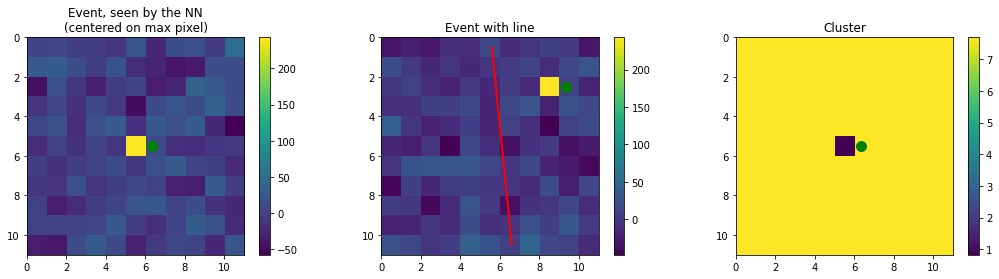

In [34]:
# Look at individual events
evt_plt = 31
evt_item = dataset_train[evt_plt]
evt_frame_cmax = np.array(evt_item[0])
evt_frame      = np.array(evt_item[1])
evt_argmax     = np.array(evt_item[2])
evt_err        = np.array(evt_item[3])/emnet.PIXEL_SIZE
evt_lside      = np.array(evt_item[4])
evt_line_m     = evt_item[5]
evt_line_b     = evt_item[6]
print("Light side is",evt_lside)
print("Arg max is",evt_argmax)

evt_frame_cmax = np.copy(np.flip(evt_frame_cmax,axis=0))

# Information for drawing the line.
nrows = evt_frame.shape[0]
ncols = evt_frame.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
print("Line drawn: m = {}, b = {}".format(evt_line_m,evt_line_b))

# Run the model and compute the reconstructed point.
data = torch.tensor(evt_frame_cmax).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(data)
pred_err = np.array(output_score.cpu().detach().numpy()).squeeze()
row_pred = pred_err[1] + evt_argmax[0] + 0.5
col_pred = pred_err[0] + evt_argmax[1] + 0.5
print("Pred point (",col_pred,",",row_pred,")")
print("Pred vector (",pred_err[0],",",pred_err[1],")")

# Compute the distance from the reconstructed point to the line.
dist_pred = (evt_line_m*col_pred - row_pred + evt_line_b) / (evt_line_m**2 + 1)**0.5
print("Predicted distance to the line:",dist_pred)

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_frame_cmax,extent=[0,11,11,0])
#ax1.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax1.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event, seen by the NN\n(centered on max pixel)")

ax2 = fig.add_subplot(132)
plt.imshow(evt_frame,extent=[0,11,11,0])
#ax2.plot([col_true],[row_true],color='red',marker='*',markersize=10)
ax2.plot([col_pred],[row_pred],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Event with line")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)],linewidth=2,color='red')

# Compute a test loss
batch_size = 1
indices = np.indices((emnet.EVT_SIZE,emnet.EVT_SIZE))
row_coords = torch.tensor(indices[0] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
col_coords = torch.tensor(indices[1] + 0.5 - ((emnet.EVT_SIZE-1)/2 + 0.5)).repeat([batch_size,1,1]).cuda()
print("TEST LOSS")
#loss_vec, loss_dist = tr.loss_reg_edge(torch.tensor([[evt_err[0],evt_err[1]]]), np.array([evt_argmax]), line_m, line_b, evt_lside)
loss_vec, loss_dist, dist_reco_masked = tr.loss_reg_edge(data.squeeze(1), torch.tensor(evt_item[3]).unsqueeze(0).cuda(), output_score, row_coords, col_coords, torch.tensor([evt_argmax]).cuda(), evt_line_m, evt_line_b, evt_lside)
print("-- Test vector loss:",loss_vec)
print("-- Test distance loss:",loss_dist)

ax3 = fig.add_subplot(133)
plt.imshow(dist_reco_masked.cpu().detach().squeeze(0).numpy(),extent=[0,11,11,0])
#ax3.plot([evt_err[0]+5.5],[evt_err[1]+5.5],color='red',marker='*',markersize=10)
ax3.plot([pred_err[0]+5.5],[pred_err[1]+5.5],color='green',marker='o',markersize=10)
plt.colorbar()
plt.title("Cluster")
xfit = np.arange(0,ncols-1,0.1)
yfit = evt_line_m*xfit + evt_line_b

print("COMPARE LOSS")
if(evt_lside == 1):
    dist_pred *= -1
sigma_dist = 2
loss_vec = (pred_err[0]**2 + pred_err[1]**2)
loss_dist = np.exp(-dist_pred/sigma_dist)
print("-- Distance is:",dist_pred)
print("-- Compare vector loss:",loss_vec)
print("-- Compare distance loss:",loss_dist)
#print("True vector is ({},{})".format(evt_vec[0],evt_vec[1]))
#print("Predicted vector is ({},{})".format(pred_vec[0],pred_vec[1]))

## Backup code

In [ ]:
ydata = img_th_proc[480,208:308]
xdata = np.arange(len(ydata)) + 208

p0 = [max(ydata), np.median(xdata), 1, min(ydata)] # this is an mandatory initial guess
popt, pcov = curve_fit(sigmoid, xdata, ydata,p0, method='dogbox')

x = np.linspace(xdata[0], xdata[-1], 1000)
y = sigmoid(x, *popt)

plt.plot(xdata, ydata, label='data')
plt.plot(x,y, label='fit')
plt.legend(loc='best')
print("Best fit parameters: L = {}, x0 = {}, k = {}, b = {}".format(popt[0],popt[1],popt[2],popt[3]))

In [ ]:
#plt.imshow(np.average(imgs_medsub,axis=0))
plt.imshow(imgs_th[0][0:11,0:11])
plt.colorbar()

In [ ]:
subimg_halfsize = 5
rmin = 0
rmax = len(available_edges)
cmin = 0
cmax = imgs_th.shape[2]
    
# For each individual thresholded image, choose the sub-images.
valid_subimages_th, valid_subimages = [], []
line_m, line_b = [], []
for iimg in range(1): #len(imgs_th.shape[0]))
    
    img    = imgs[iimg]
    img_th = imgs_th[iimg]
    
    done = (available_edges == -1).all()

    while(not done):
        
        # Choose a random location in the x-edges array.
        rmid = np.random.randint(rmax)
        
        # Make sure the current edge is available.
        if(available_edges[rmid] < 0):
            continue
        
        # Select a window equal to the subimage size in length.
        rstart = rmid - subimg_halfsize
        rend   = rmid + subimg_halfsize + 1
        if(rstart < rmin or rend >= rmax):
            if(rstart < rmin): rstart = rmin
            if(rend >= rmax):  rend = rmax
            available_edges[rstart:rend] = -1
            continue
        
        # Ensure all edges for this image have not yet been used.
        aedges = available_edges[rstart:rend]
        if((aedges > 0).all()):
        
            # Construct the subimage.
            xmid = x_edges[rmid]
            cstart = xmid - subimg_halfsize
            cend   = xmid + subimg_halfsize + 1
            
            # Only continue with a subimage that fits properly in the full image.
            if(cstart >= cmin and cend < cmax):
                
                # Create the subimage.
                subimg    = img[rstart:rend,cstart:cend]
                subimg_th = img_th[rstart:rend,cstart:cend]

                # Check that the (thresholded) subimage is valid.
                if(check_subimage_th(subimg_th)):
                    
                    # Compute the slopes and intercepts.
                    x1 = (x_edges[rstart] - cstart) + 0.5
                    x2 = (x_edges[rend] - cstart) + 0.5
                    if(x2 == x1): x2 = x1-1
                    y1 = 0.5
                    y2 = (rend - rstart) - 0.5
                    m = (y2 - y1) / (x2 - x1)
                    b = y2 - m*x2
                    print("xmid_rel = {}, cstart = {}, cend = {}".format(xmid-cstart,cstart,cend))
                    print("(x1,y1) = ({},{}); (x2,y2) = ({},{})".format(x1,y1,x2,y2))
                    line_m.append(m)
                    line_b.append(b)

                    # Save the subimage.
                    valid_subimages.append(subimg)
                    valid_subimages_th.append(subimg_th)

                    # Remove all edges for this subimage from availability.
                    available_edges[rstart:rend] = -1

                # If the image is not valid, do nothing, but continue the loop.
                
            else:
                available_edges[rstart:rend] = -1
           
        # If not all edges are available, 
        else:
            available_edges[rstart:rend] = -1
        
        # Set the terminating condition.
        done = (available_edges == -1).all()
        print("Number of available edges:",np.sum(available_edges == 1),"/",len(available_edges))

line_m = np.array(line_m)
line_b = np.array(line_b)
valid_subimages = np.array(valid_subimages)
valid_subimages_th = np.array(valid_subimages_th)

# Generate random multi-electron events

In [ ]:
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

In [ ]:
frameset  = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0, lside = 0, res_factor=3)
#frameset = tr.EMFrameDataset(dset,frame_size=4855,nelec_mean=103713,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=88,nelec_sigma=2,noise_mean=0,noise_sigma=20)
#frameset = tr.EMFrameDataset(dset,frame_size=100,nelec_mean=10,nelec_sigma=1,noise_mean=0,noise_sigma=20)

##### Generate many frames and fit

In [ ]:
def fit_line(fit_img, th = 0.5, pct_rng = 0.2, nbins_hdist = 80):
    
    A = fit_img/np.mean(fit_img)
    nrows = A.shape[0]
    ncols = A.shape[1]
    ncts = np.sum(A[A >= th])
    nzeros = np.sum(1-A[A < th])
    wcts = 1 #nzeros/ncts
    indices = np.indices((nrows,ncols))
    irows = indices[0]
    icols = indices[1]
    print("nzeros = {}, ncts = {}, wcts = {}".format(nzeros,ncts,wcts))

    def count_loss(x):
        m,b = x

        # The loss L is:
        #
        # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
        # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
        # 
        # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
        # the number of zeros.
        L = 0
        L1 = np.sum(1-A[(irows < m*icols + b) & (A < th)])
        L2 = np.sum(A[(irows < m*icols + b) & (A >= th)])
        L3 = np.sum(A[(irows >= m*icols + b) & (A >= th)])
        L4 = np.sum(1-A[(irows >= m*icols + b) & (A < th)])

        L = L1 - wcts*L2 + wcts*L3 - L4
        #print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
        return -L
    
    initial_guess = [-1.5*nrows/ncols,2.0*nrows]
    result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-5)
    m,b = result.x
    Lmin = result.fun
    print("m = ",m,"b = ",b,"Lmin=",Lmin)
    
    # Force m and b.
    m = -2.0
    b = 90.0
    print("NOTE: hard-coding m and b")
    
    # Get the loss over a range of the parameters.
    mrng = np.arange(m-pct_rng*m, m+pct_rng*m, 2*pct_rng*m/1000)
    Lrng_m = np.array([count_loss([mval,b])/Lmin for mval in mrng])
    brng = np.arange(b-pct_rng*b, b+pct_rng*b, 2*pct_rng*b/1000)
    Lrng_b = np.array([count_loss([m,bval])/Lmin for bval in brng])
    
    # Get the histogram of mean value vs. distance.
    dist = (5./3.)*(m*icols - irows + b) / (m**2 + 1)                          # compute distance to line for each point
    hw, bb = np.histogram(dist.flatten(),weights=A.flatten(),bins=nbins_hdist)  # weighted histogram
    hh, bb = np.histogram(dist.flatten(),bins=nbins_hdist)                      # unweighted (for normalization)
    hh[hh == 0] = 0.1
    hfinal = hw / hh                                                   # normalize the histogram
    bcenters = (bb[1:] + bb[:-1]) / 2                                  # determine the bin centers
    
    return m,b,Lmin,mrng,Lrng_m,brng,Lrng_b,hfinal,bcenters

# Fit the S-curve to a sigmoid.
def fit_scurve():
    

In [ ]:
# Create some number of events and count them.
th_unet = 0.2
th_classical = 825/4.
evts = np.arange(0,100000)
l_frames, l_labels, l_ct_unet, l_ct_classical = [], [], [], []
for evt in evts:
    frame,label = frameset[evt]
    gnd_truth = label[0]
    
    # Send through the model.
    data = torch.tensor(frame).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    ct_unet = (prob > th_unet)
    
    # Count with a single threshold.
    #ct_classical = (frame > th_classical)
    
    # Max argument classical truth.
    #ct_classical = np.zeros(frame.shape)
    #ct_classical[np.unravel_index(np.argmax(frame),frame.shape)] = 1
    
    # Threshold truth.
    ct_classical = label[1]
    
    l_frames.append(frame)
    l_labels.append(gnd_truth)
    l_ct_unet.append(ct_unet)
    l_ct_classical.append(ct_classical)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
            
l_frames = np.array(l_frames)
l_labels = np.array(l_labels)
l_ct_unet = np.array(l_ct_unet)
l_ct_classical = np.array(l_ct_classical)

# Create a summed frame, label, and count arrays.
frame = np.sum(l_frames,axis=0)
label = np.sum(l_labels,axis=0)
ct_unet = np.sum(l_ct_unet,axis=0)
ct_classical = np.sum(l_ct_classical,axis=0)

In [ ]:
raw_th = 0.99
ct_th = 0.1
m_frame,b_frame,Lmin_frame,mrng_frame,Lrng_m_frame,brng_frame,Lrng_b_frame,hdist_frame,bcenters_frame = fit_line(frame,th=raw_th)
m_label,b_label,Lmin_label,mrng_label,Lrng_m_label,brng_label,Lrng_b_label,hdist_label,bcenters_label = fit_line(label,th=ct_th)
m_unet,b_unet,Lmin_unet,mrng_unet,Lrng_m_unet,brng_unet,Lrng_b_unet,hdist_unet,bcenters_unet = fit_line(ct_unet,th=ct_th)
m_classical,b_classical,Lmin_classical,mrng_classical,Lrng_m_classical,brng_classical,Lrng_b_classical,hdist_classical,bcenters_classical = fit_line(ct_classical,th=ct_th)

In [ ]:
#frame,label = frameset[0]
logscale = False
nrows = frame.shape[0]
ncols = frame.shape[1]

fig = plt.figure()
fig.set_figheight(12.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(221)
if(logscale):
    plt.imshow(np.log(frame))
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    #plt.title("Raw frame (log counts, threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame (log counts)\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
else:
    plt.imshow(frame/np.max(frame))
    cbar = plt.colorbar()
    #plt.title("Raw frame (threshold = {})\nm = {:.2f}, b = {:.2f}".format(raw_th,m_frame,b_frame))
    plt.title("Raw frame\nm = {:.2f}, b = {:.2f}".format(m_frame,b_frame))
xfit = np.arange(0,ncols-1,0.1)
yfit = m_frame*xfit + b_frame
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax2 = fig.add_subplot(222)
plt.imshow(label/np.max(label))
#plt.title("Truth (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_label,b_label))
plt.title("Truth\nm = {:.2f}, b = {:.2f}".format(m_label,b_label))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_label*xfit + b_label
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax3 = fig.add_subplot(223)
plt.imshow(ct_unet/np.max(ct_unet))
#plt.title("UNet counts (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_unet,b_unet))
plt.title("UNet counts\nm = {:.2f}, b = {:.2f}".format(m_unet,b_unet))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_unet*xfit + b_unet
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

ax4 = fig.add_subplot(224)
plt.imshow(ct_classical/np.max(ct_classical))
#plt.title("Classical counts + line info (threshold = {})\nm = {:.2f}, b = {:.2f}".format(ct_th,m_classical,b_classical))
plt.title("Classical counts + line info\nm = {:.2f}, b = {:.2f}".format(m_classical,b_classical))
plt.colorbar()
xfit = np.arange(0,ncols-1,0.1)
yfit = m_classical*xfit + b_classical
plt.plot(xfit[(yfit > 0) & (yfit < nrows-1)],yfit[(yfit > 0) & (yfit < nrows-1)],color='red',linewidth=2)

print("Total counts, truth:",np.sum(label))
print("Total counts, classical:",np.sum(ct_classical))
print("Total counts, unet:",np.sum(ct_unet))

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(hdist_frame))

ax1 = fig.add_subplot(121)
plt.plot(bcenters_frame,frame_mult*(hdist_frame-min(hdist_frame)),'.-',color='black',label='frame')
plt.plot(bcenters_label,hdist_label,'.-',color='green',label='true')
plt.plot(bcenters_unet,hdist_unet,'.-',color='blue',label='UNet')
plt.plot(bcenters_classical,hdist_classical,'.-',color='red',label='classical+line')
plt.xlim([-10,10])
plt.ylim([0.0,3.2])
plt.xlabel("Distance from line (micrometers)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

In [ ]:
# Save s-curve information.
np.savez("scurve_edge_th02_epoch10.npz", bcenters_frame=bcenters_frame, hdist_frame=hdist_frame, bcenters_label=bcenters_label, hdist_label=hdist_label, 
         bcenters_unet=bcenters_unet, hdist_unet=hdist_unet, bcenters_classical=bcenters_classical, 
         hdist_classical=hdist_classical)

In [ ]:
fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121)
plt.plot(mrng_frame/m_frame,Lrng_m_frame,color='black',label='frame')
plt.plot(mrng_label/m_label,Lrng_m_label,color='green',label='true')
plt.plot(mrng_unet/m_unet,Lrng_m_unet,color='blue',label='UNet')
plt.plot(mrng_classical/m_classical,Lrng_m_classical,color='red',label='classical')
plt.xlabel("Parameter m/m$_0$")
plt.ylabel("Relative loss L/L(m$_0$)")
plt.legend()

ax2 = fig.add_subplot(122)
plt.plot(brng_frame/b_frame,Lrng_b_frame,color='black',label='frame')
plt.plot(brng_label/b_label,Lrng_b_label,color='green',label='true')
plt.plot(brng_unet/b_unet,Lrng_b_unet,color='blue',label='UNet')
plt.plot(brng_classical/b_classical,Lrng_b_classical,color='red',label='classical')
plt.xlabel("Parameter b/b$_0$")
plt.ylabel("Relative loss L/L(b$_0$)")
plt.legend()

In [ ]:
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

#### Plot s-curve data

In [ ]:
scurve_noedge = np.load("scurve_noedge_th088.npz")
bc_label_noedge = scurve_noedge['bcenters_label']
h_label_noedge = scurve_noedge['hdist_label']
bc_unet_noedge = scurve_noedge['bcenters_unet']
h_unet_noedge = scurve_noedge['hdist_unet']
bc_classical_noedge = scurve_noedge['bcenters_classical']
h_classical_noedge = scurve_noedge['hdist_classical']

scurve_edge = np.load("scurve_edge_th08.npz")
bc_frame_edge = scurve_edge['bcenters_frame']
h_frame_edge = scurve_edge['hdist_frame']
bc_label_edge = scurve_edge['bcenters_label']
h_label_edge = scurve_edge['hdist_label']
bc_unet_edge = scurve_edge['bcenters_unet']
h_unet_edge = scurve_edge['hdist_unet']
bc_classical_edge = scurve_edge['bcenters_classical']
h_classical_edge = scurve_edge['hdist_classical']

scurve_edge10 = np.load("scurve_edge_th08_epoch10.npz")
bc_label_edge10 = scurve_edge10['bcenters_label']
h_label_edge10 = scurve_edge10['hdist_label']
bc_unet_edge10 = scurve_edge10['bcenters_unet']
h_unet_edge10 = scurve_edge10['hdist_unet']
bc_classical_edge10 = scurve_edge10['bcenters_classical']
h_classical_edge10 = scurve_edge10['hdist_classical']

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

frame_mult = 1./(1.-min(h_frame_edge))

ax1 = fig.add_subplot(111)
plt.plot(bc_frame_edge,frame_mult*(h_frame_edge-min(h_frame_edge)),'.-',color='black',label='raw frame, scaled')
plt.plot(bc_classical_edge,h_classical_edge,'.-',color='red',label='classical')
plt.plot(bc_unet_noedge,h_unet_noedge,'.-',color='orange',label='UNet, no edge, epoch 500')
plt.plot(bc_unet_edge10,h_unet_edge10,'.-',color='cyan',label='UNet + edge, epoch 11')
plt.plot(bc_unet_edge,h_unet_edge,'.-',color='blue',label='UNet + edge, epoch 500')
plt.plot(bc_label_edge,h_label_edge,'.-',color='green',label='true')
plt.xlim([-5,5])
plt.ylim([0.0,1.0])
plt.xlabel("Distance from line (pixels)")
plt.ylabel("Mean number of normalized counts")
plt.legend()

##### Examine a large generated frame

In [ ]:
plt.imshow(label[0,0:50,0:50])
plt.colorbar()

In [ ]:
img_sim = frame.flatten()

In [ ]:
#plt.hist(img_sim[(img_sim < 400)],bins=50)
plt.hist(img_sim,bins=50)
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
print("Total pixels:",len(img_sim))
#plt.xlim([0,500])

In [ ]:
np.savez("frame_4855x4855_11occ.npz",frame=frame)

## Train a network (multi-electron)

In [ ]:
modeldir = '/home/jrenner/local/jerenner/emsim/models'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 200    # Number of final epoch
model_load_checkpoint = "{}/model_init_199.pt".format(modeldir)

# Create the dataset.
# 576x576: 2927 +/- 71
# 100x100: 88 +/- 2
# 50x50: 22 +/- 0.5
#dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)

# "Real-data-like" dataset: occupancy 11, noise_mean=683, noise_sigma=11.2
dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
dataset_train = tr.EMFrameDataset(dset,frame_size=20,nelec_mean=2,nelec_sigma=0.1,noise_mean=683,noise_sigma=11.2,m_line=-2.0,b_line=30.0,res_factor=3)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=50, shuffle=False, collate_fn=tr.my_collate_unet, num_workers=1)

# Define the model.
model = UNet(n_channels=1, n_classes=1)
model.cuda()

optimizer = optim.RMSprop(model.parameters(), lr=lrate, weight_decay=1e-8, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    train_loss = tr.train_unet(model, epoch, train_loader, optimizer)
    scheduler.step(train_loss)
    #if(epoch % 50 == 0):
    torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_frames_20x20_noise683_2e_bcsloss_edge_unweighted_front_1em4_100kev_{}.pt".format(modeldir,epoch))

In [ ]:
# Plot the training loss and accuracy.
tloss = np.loadtxt("train.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.legend()
plt.title("Accuracy")

#### Test the net

In [ ]:
sigmoid = nn.Sigmoid()
#dset = tr.EMDataset("dataframes/EM_5um_front_3M_100keV.pkl",noise_mean=0,noise_sigma=20,add_noise=False,add_shift=0)
#dataset_train   = tr.EMFrameDataset(dset,frame_size=50,nelec_mean=11,nelec_sigma=0.5,noise_mean=683,noise_sigma=11.2)
model.eval()

In [ ]:
# Loop over many events and evaluate the true positives and false positives.
# Store in arrays as:
#
#  [tp0 tp1 tp2 tp3 ... tpN], each number corresponding to a different NN threshold or classical threshold
#
tp_unet = []; fp_unet = []
tp_classical = []; fp_classical = []
#nn_thresholds = np.arange(0.05,1.0,0.1)
nn_thresholds = np.concatenate((np.logspace(-4,-0.1,500), np.logspace(-0.1,0,500)))
#nn_thresholds = np.logspace(-3,0,1000)
classical_thresholds = np.arange(600/4,7000/4,10)
evts = np.arange(100000,101000)
for evt in evts:
    
    # Get the event and truth.
    evt_item = dataset_train[evt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1][0]
    
    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    output_score = model(data)
    
    # Compute the predicted pixel values.
    prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()
    
    # Compute the TP and FP values for unet.
    temp_tp = []; temp_fp = []
    for th in nn_thresholds:
        pred = (prob > th)
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (fp + tn) > 0): fp = fp / (fp + tn)
        else: fp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_unet.append(temp_tp)
    fp_unet.append(temp_fp)
    
    # Compute the TP and FP values for the classical threshold.
    temp_tp = []; temp_fp = []
    for th in classical_thresholds:
        #pred = (evt_arr > th)
        pred = np.zeros(evt_arr.shape)
        pred[np.unravel_index(np.argmax(evt_arr),evt_arr.shape)] = 1
        tp = np.sum((evt_lbl == 1) & (pred == True))
        fn = np.sum((evt_lbl == 1) & (pred == False))
        if( (tp + fn) > 0): tp = tp / (tp + fn)
        else: tp = 1
        fp = np.sum((evt_lbl == 0) & (pred == True))
        tn = np.sum((evt_lbl == 0) & (pred == False))
        if( (tp + tn) > 0): fp = fp / (fp + tn)
        else: tp = 0
        temp_tp.append(tp)
        temp_fp.append(fp)
    tp_classical.append(temp_tp)
    fp_classical.append(temp_fp)
    
    if((evt-evts[0]) % (len(evts)/100) == 0):
            print("{}% done".format(int((evt-evts[0]) / (len(evts)/100))))
    
tp_unet = np.array(tp_unet)
fp_unet = np.array(fp_unet)
tp_classical = np.array(tp_classical)
fp_classical = np.array(fp_classical)

In [ ]:
tp_rate_unet = np.mean(tp_unet,axis=0)
tp_err_unet = np.std(tp_unet,axis=0)/np.sqrt(tp_unet.shape[0])
fp_rate_unet = np.mean(fp_unet,axis=0)
fp_err_unet = np.std(fp_unet,axis=0)/np.sqrt(fp_unet.shape[0])
tp_rate_classical = np.mean(tp_classical,axis=0)
tp_err_classical = np.std(tp_classical,axis=0)/np.sqrt(tp_classical.shape[0])
fp_rate_classical = np.mean(fp_classical,axis=0)
fp_err_classical = np.std(fp_classical,axis=0)/np.sqrt(fp_classical.shape[0])

plt.errorbar(fp_rate_unet,tp_rate_unet,xerr=fp_err_unet,yerr=tp_err_unet,label='Unet')
plt.errorbar(fp_rate_classical,tp_rate_classical,xerr=fp_err_classical,yerr=tp_err_classical,label='Basic threshold')
plt.xlim([0,0.02])
plt.legend()
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")

In [ ]:
print("NN ------------------")
for tpr,fpr,th in zip(tp_rate_unet,fp_rate_unet,nn_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))
print("Classical threshold ------------------")
for tpr,fpr,th in zip(tp_rate_classical,fp_rate_classical,classical_thresholds):
    print("[Threshold {}] TP = {}, FP = {}".format(th,tpr,fpr))

In [ ]:
evt_plt = 10008
evt_item = dataset_train[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1][1]

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
#target = torch.tensor(evt_lbl).float().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

# Threshold
# prob = np.zeros(evt_arr.shape)
# prob[evt_arr > 80] = 1

# Determine number of correct pixels
th = 0.2
pred = (prob > th)
nelec = int(np.sum(evt_lbl == 1))
nelec_pred = int(np.sum(pred))
nspace = int(np.sum(evt_lbl == 0))
nelec_coinc = np.sum((evt_lbl == 1) & (pred == True))
nspace_coinc = np.sum((evt_lbl == 0) & (pred == False))
print("{}/{} electrons predicted".format(nelec_pred,nelec))
print("{}/{} electrons coincided exactly".format(nelec_coinc,nelec))
print("{}/{} empty spaces coincided exactly".format(nspace_coinc,nspace))

# Information for drawing the line.
nrows = evt_arr.shape[0]
ncols = evt_arr.shape[1]
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]
m = -2*nrows/ncols
b = 80
print("Line drawn: m = {}, b = {}".format(m,b))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event")

# xfit = np.arange(0,ncols,0.1)
# yfit = m*xfit + b
# plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

ax2 = fig.add_subplot(132)
plt.imshow(evt_lbl)
plt.colorbar()
plt.title("Target")

ax3 = fig.add_subplot(133)
#plt.imshow(np.log10(prob))
plt.imshow(prob)
plt.colorbar()
plt.title("{}/{} electrons predicted\n{}/{} electrons coincided exactly\n{}/{} empty spaces coincided exactly".format(nelec_pred,nelec,nelec_coinc,nelec,nspace_coinc,nspace))

#### Test loss function

In [ ]:
# Construct output and label arrays for 5 events.
frames,outputs,labels = [], [], []
for iframe in range(50):
    frame,label = frameset[iframe]
    frames.append(frame)
    outputs.append(label[1])
    labels.append(label)
frames = np.array(frames)
outputs = np.array(outputs)
labels = np.array(labels)
print("Frames shape is:",frames.shape)
print("Outputs shape is:",outputs.shape)
print("Labels shape is:",labels.shape)

# Convert to tensors.
outputs[outputs == 0] = 1e-10
outputs[outputs == 1] = 0.99999999
frames = torch.tensor(frames)
output = torch.tensor(np.log(outputs/(1-outputs)))
target = torch.tensor(labels)

# Compute the loss.
sigma_dist = 1
real_truth = target[:,0,:,:]
th_truth = target[:,1,:,:]
edge_truth = target[:,2,:,:]
dist = target[:,3,:,:]

final_truth = th_truth * edge_truth

wts     = torch.sum(torch.exp(-(dist)**2/(2*sigma_dist**2))*th_truth,axis=(1,2))
wt_norm = torch.sum(th_truth,axis=(1,2))
wt_norm[wt_norm == 0] = 1
wts /= wt_norm
print("Weights are: ",wts)

w_edge = 100
bce_loss = torch.nn.BCEWithLogitsLoss(reduce=False)
sigmoid = torch.nn.Sigmoid()
loss0 = bce_loss(output,final_truth)
loss1 = w_edge*sigmoid(output)*(1-edge_truth)
loss0W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0)
loss1W = torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss1)
loss = torch.mean(torch.exp(-(dist)**2/(2*sigma_dist**2))*(loss0 + loss1))
print("Mean loss is ",loss)
print("Mean loss0 is ",torch.mean(loss0))
print("Mean loss0W is ",torch.mean(loss0W))
print("Mean loss1 is ",torch.mean(loss1))
print("Mean loss1W is ",torch.mean(loss1W))

In [ ]:
dist_mod = torch.sum(torch.abs(dist*(edge_truth-1)),axis=(1,2))
dist_mod.shape

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(16.0)

ax1 = fig.add_subplot(241)
if(show_sum): plt.imshow(np.sum(np.array(sigmoid(output)),axis=0),interpolation=None)
else: plt.imshow(np.array(sigmoid(output[iframe])),interpolation=None)
plt.colorbar()
plt.title("sigmoid(Output)")

ax2 = fig.add_subplot(242)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(243)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax4 = fig.add_subplot(244)
if(show_sum): plt.imshow(np.sum(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))),axis=0))
else: plt.imshow(np.array(torch.exp(-(dist)**2/(2*sigma_dist**2))[iframe]))
plt.colorbar()
plt.title("Distance")

ax5 = fig.add_subplot(245)
if(show_sum): plt.imshow(np.sum(np.array(loss0), axis=0))
else: plt.imshow(np.array(loss0[iframe]))
plt.colorbar()
plt.title("Loss0")

ax6 = fig.add_subplot(246)
if(show_sum): plt.imshow(np.sum(np.array(loss1),axis=0))
else: plt.imshow(np.array(loss1[iframe]))
plt.colorbar()
plt.title("Loss1")

ax7 = fig.add_subplot(247)
if(show_sum): plt.imshow(np.sum(np.array(loss0W + loss1W),axis=0))
else: plt.imshow(np.array(loss0W[iframe] + loss1W[iframe]))
# if(show_sum): plt.imshow(np.sum(np.array(dist_mod),axis=0))
# else: plt.imshow(np.array(dist_mod[iframe]))
plt.colorbar()
plt.title("LossW")

In [ ]:
iframe = 2
show_sum = False

fig = plt.figure()
fig.set_figheight(3.0)
fig.set_figwidth(20.0)

ax1 = fig.add_subplot(151)
if(show_sum): plt.imshow(np.sum(frames,axis=0)/np.max(np.sum(frames,axis=0)),interpolation=None)
else: plt.imshow(np.array(frames[iframe]),interpolation=None)
plt.colorbar()
plt.title("Event")

ax2 = fig.add_subplot(152)
if(show_sum): plt.imshow(np.sum(np.array(real_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(real_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Real truth")

ax3 = fig.add_subplot(153)
if(show_sum): plt.imshow(np.sum(np.array(th_truth),axis=0),interpolation=None)
else: plt.imshow(np.array(th_truth[iframe]),interpolation=None)
plt.colorbar()
plt.title("Classical threshold")

ax4 = fig.add_subplot(154)
if(show_sum): plt.imshow(np.sum(np.array(edge_truth), axis=0))
else: plt.imshow(np.array(edge_truth[iframe]))
plt.colorbar()
plt.title("Edge truth")

ax5 = fig.add_subplot(155)
if(show_sum): plt.imshow(np.sum(np.array(final_truth), axis=0))
else: plt.imshow(np.array(final_truth[iframe]))
plt.colorbar()
plt.title("Combined truth")

##### Test on real data

In [ ]:
# Evaluate real data
img_data_cut = img_data[-1023:,-1440:]/12
img_data_torch = torch.tensor(img_data_cut).float().unsqueeze(0).unsqueeze(1).cuda()
output_score = model(img_data_torch)
prob = np.array(sigmoid(output_score).cpu().detach().numpy()).squeeze()

In [ ]:
# Plot the results of the real data evaluation
logscale = False
view_row_low = -350
view_row_high = -300
view_col_low = -350
view_col_high = -300

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
if(logscale):
    plt.imshow(np.log(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high]),interpolation='none')
    cbar = plt.colorbar()
    cbar.set_label("log(counts)")
    plt.title("Scaled data (log counts)")
else:
    plt.imshow(img_data_cut[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none') #np.log(frame))
    cbar = plt.colorbar()
    plt.title("Scaled data")

ax2 = fig.add_subplot(122);
plt.imshow(prob[view_row_low:view_row_high,view_col_low:view_col_high],interpolation='none')
plt.title("U-net output")
plt.colorbar()

In [ ]:
prob.shape

## Real data

In [ ]:
import struct
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimize

In [ ]:
# From https://stackoverflow.com/questions/1035340/reading-binary-file-and-looping-over-each-byte
def bytes_from_file(filename, chunksize=4):
    with open(filename, "rb") as f:
        while True:
            chunk = f.read(chunksize)
            if chunk:
                yield struct.unpack('@I', chunk)[0]
            else:
                break

In [ ]:
datfile = "/home/jrenner/local/data/electronsim/stack_1.dat"
freader = iter(bytes_from_file(datfile))

In [ ]:
img = []
for i in range(5760*4092):
    img.append(next(freader))
img = np.array(img)

In [ ]:
# Prepare for input to a NN
img_data = img.reshape([4092,5760])

In [ ]:
#plt.imshow(np.log(img.reshape([5760,4092])),vmin=9.5,vmax=10.5)
#plt.imshow(img.reshape([5760,4092])[-100:,0:100],vmin=750,vmax=10000)
plt.imshow(img_data,interpolation='none',vmin=750,vmax=15000)
plt.colorbar()

## Attempt to fit the edge

In [ ]:
noise_th = 750*12
max_th = 751*12
fit_img = np.copy(img_data)
fit_img[fit_img < noise_th] = 0
fit_img[fit_img >= noise_th] = max_th
fit_img = fit_img/np.max(fit_img)
fit_img = np.array(fit_img,dtype=np.uint8)
print("Min value:",np.min(fit_img),"; max value:",np.max(fit_img))

In [ ]:
plt.imshow(fit_img,interpolation='none')
plt.colorbar()

In [ ]:
A = fit_img
th = 0.5
nrows = A.shape[0]
ncols = A.shape[1]
ncts = np.sum(A >= th)
nzeros = np.sum(A < th)
wcts = nzeros/ncts
indices = np.indices((nrows,ncols))
irows = indices[0]
icols = indices[1]

def count_loss(x):
    m,b = x
    
    # The loss L is:
    #
    # (number of 0s in the dark region) - wcts*(number of 1s in the dark region)
    # + wcts*(number of 1s in the light region) - (number of 0s in the dark region)
    # 
    # where wcts is the count weight, determined such that the number of counts multiplied by wcts is equal to
    # the number of zeros.
    L = 0
    L1 = np.sum((irows < m*icols + b) & (A < th))
    L2 = np.sum((irows < m*icols + b) & (A >= th))
    L3 = np.sum((irows >= m*icols + b) & (A >= th))
    L4 = np.sum((irows >= m*icols + b) & (A < th))
    
    L = L1 - wcts*L2 + wcts*L3 - L4
    print("Loss is:",-L,"with L1 =",L1,"L2 =",L2,"L3 =",L3,"L4 =",L4)
    return -L

In [ ]:
initial_guess = [-nrows/ncols,nrows]
result = optimize.minimize(count_loss,initial_guess,method='Nelder-Mead',tol=1e-6)
m,b = result.x
Lmin = result.fun
print("m = ",m,"b = ",b,"Lmin=",Lmin)

In [ ]:
plt.imshow(fit_img,interpolation='none')
xfit = np.arange(ncols)
yfit = m*xfit + b
plt.plot(xfit[(yfit > 0) & (yfit < nrows)],yfit[(yfit > 0) & (yfit < nrows)])

In [ ]:
# Plot the loss in a range near the parameters.
mrng = np.arange(m-0.1*m, m+0.1*m, 0.2*m/100)
Lrng = np.array([count_loss([mval,b])/Lmin for mval in mrng])
print(mrng)
plt.plot(mrng,Lrng)
plt.xlabel("Parameter m")
plt.ylabel("Relative loss L/L(m$_0$)")

In [ ]:
def auto_canny(image, sigma=0.1):
    v = 255/2. #np.median(image)
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    print("Lower =",lower,", upper=",upper)
    return cv2.Canny(image, lower, upper)

edges = auto_canny(image=fit_img) 

# Show images for testing
#cv2.imshow('edges', edges)
plt.imshow(edges)
plt.colorbar()

## Fit the noise peak

In [ ]:
fscale = 12.

def gauss(x, amp, mu, sigma):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2)

def gaussexpo(x, amp, mu, sigma, const, mean, x0):
    if sigma <= 0.:
        return np.inf
    return amp/(2*np.pi)**(0.5)/sigma * np.exp(-0.5*(x-mu)**2./sigma**2) + const * np.exp(-(x-x0)/mean)


yh, xh, _ = plt.hist(img[(img/fscale > 7000/fscale) & (img/fscale < 9300/fscale)]/fscale,bins=50)
xh = (xh[1:] + xh[0:-1])/2

#popt, pcov = curve_fit(gaussexpo, xh, yh, [3.0e6, 8200, 300, 1000, 10, -1])
popt, pcov = curve_fit(gauss, xh, yh, [3.0e6, 8200/fscale, 135/fscale])
xfit = np.linspace(xh[0],xh[-1],100)
plt.plot(xfit,gauss(xfit,*popt))
plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
print("Fit mean:",popt[1])
print("Fit sigma:",popt[2])

In [ ]:
fn = np.load("frame_4855x4855_11occ.npz")
img_sim = fn['frame'].flatten()

In [ ]:
#plt.hist(img[(img > 0) & (img < 10000)],bins=50)
plt.hist(img_sim,bins=50,range=[0,10000],label='MC')
plt.hist(img/12,bins=50,range=[0,10000],label='data')

plt.xlabel("Pixel values")
plt.ylabel("Counts/bin")
plt.yscale("log")
plt.legend()
print("Total pixels:",len(img))
print("Counts near peak",np.sum(img[(img > 29) & (img < 33)]))

In [ ]:
177383690/935130034.

In [ ]:
plt.hist(np.abs(np.random.normal(loc=0,scale=50,size=1000)))

## Train a network (single-electrons)

In [ ]:
#modeldir = '/home/jrenner/local/jerenner/emsim/models'\
modeldir = '/home/jrenner/temp/nersc'
lrate       = 1e-3   # Learning rate to use in the training.
load_model  = False   # Load an existing model
tr.augment  = False  # Enable/disable data augmentation
epoch_start = 0      # Number of initial epoch
epoch_end   = 2000    # Number of final epoch
model_load_checkpoint = "{}/run_11x11_chi32_60/model_init_599.pt".format(modeldir)

# Create the datasets.
dataset_all   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
dataset_train = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=0,nend=-20000,add_shift=0)
dataset_val   = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,nstart=-20000,add_shift=0)

# Create the loaders.
train_loader = DataLoader(dataset_train, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
val_loader = DataLoader(dataset_val, batch_size=1000, shuffle=True, collate_fn=tr.my_collate, num_workers=8)
#val_loader = DataLoader(dataset_val, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)
#test_loader = DataLoader(dataset_test, batch_size=15, shuffle=True, collate_fn=tr.my_collate, num_workers=4)

# Define the model.
#model = emnet.FCNet()
model = emnet.basicCNN()
model.cuda()

optimizer = optim.Adam(model.parameters(), lr=lrate, betas=(0.9, 0.999), eps=1e-6, weight_decay=0.01, amsgrad=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

# Load the model from file.
if(load_model):
    model.load_state_dict(torch.load(model_load_checkpoint))
    #model.load_state_dict(torch.load(model_load_checkpoint,map_location=torch.device('cpu')))
    model.eval()

In [ ]:
# Run the training.
#print("Training with weights",sort_clsweights)
for epoch in range(epoch_start,epoch_end):
    print("Epoch: ",epoch)
    model.train()
    tr.train(model, epoch, train_loader, optimizer)
    with torch.no_grad():
        model.eval()
        val_loss = tr.val(model, epoch, val_loader)
        scheduler.step(val_loss)
#     if(epoch % 50 == 0):
#         torch.save(model.state_dict(), "{}/model_init_{}.pt".format(modeldir,epoch))

In [ ]:
torch.save(model.state_dict(), "{}/model_short_training_{}.pt".format(modeldir,epoch))

### Plot the training and validation loss

In [ ]:
# Plot the training and validation losses.
tloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/train.txt")
vloss = np.loadtxt("/home/jrenner/temp/nersc/run_11x11_chi32_60_val2_trainsched/val.txt")
#vloss = np.loadtxt("/home/jrenner/local/jerenner/emsim/val.txt")

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(12.0)

ax1 = fig.add_subplot(121);
plt.plot(tloss[:,0],tloss[:,1],label='training')
plt.plot(vloss[:,0],vloss[:,1],label='validation')
plt.legend()
plt.title("Loss")
plt.yscale('log')

ax2 = fig.add_subplot(122);
plt.plot(tloss[:,0],tloss[:,2],label='training')
plt.plot(vloss[:,0],vloss[:,2],label='validation')
plt.legend()
plt.title("Accuracy")

### Evaluate all events from a dataset

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
model.eval()

In [ ]:
evts = np.arange(100000,110000)
df, evts = emsim_utils.construct_evt_dataframe(dset,evts,model)

In [ ]:
xvals = df['xc_3x3'].values
yvals = df['yc_3x3'].values
rngval = 0.002
plt.hist2d(xvals,yvals,bins=10,range=[[-rngval,rngval],[-rngval,rngval]])
plt.colorbar()

In [ ]:
axes = pd.plotting.scatter_matrix(df[["error_r_NN","error_r_maxpt","error_r_3x3","error_r_3x3_th","error_r_5x5","error_r_5x5_th"]], 
                                  figsize=[15,15], alpha=0.2, hist_kwds={'bins':100})
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        #if i == j:  # only the histograms
        #ax.set_yscale('log')
        ax.set_xlim(0,0.01)
        ax.set_ylim(0,0.01)
            
plt.savefig("errors_scatter_matrix.pdf")

In [ ]:
err_cut = 0.1
rng_cut = 0.005
sigma_cut = 1e9
nbins = 50

df_plt_NN  = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]
df_plt_3x3 = df[(df.error_r_3x3 < err_cut)] # & (df.sigma_r_NN < sigma_cut)]

plt.hist(df_plt_NN.error_r_NN,range=(0,rng_cut),alpha=0.8,bins=nbins,color='blue',label='NN error')
plt.hist(df_plt_3x3.error_r_3x3,range=(0,rng_cut),alpha=0.8,bins=nbins,color='green',label='3x3 centroid')
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("counts/bin")
#plt.yscale('log')
plt.legend()

print("NN events:",len(df_plt_NN[df_plt_NN.error_r_NN < rng_cut]))
print("3x3 events:",len(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut]))
print("Mean NN error:",np.mean(df_plt_NN[df_plt_NN.error_r_NN < rng_cut].error_r_NN))
print("Mean 3x3 error:",np.mean(df_plt_3x3[df_plt_3x3.error_r_3x3 < rng_cut].error_r_3x3))

In [ ]:
print("Mean 3x3 error:",df[(df.error_r_3x3 < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_3x3.mean())
print("Mean NN error: ",df[(df.error_r_NN < err_cut) & (df.sigma_r_NN < sigma_cut)].error_r_NN.mean())

In [ ]:
df["error_r_diff"] = df.error_r_NN - df.error_r_3x3

In [ ]:
err_diff_cut = 0.005
plt.hist(df[(df.error_r_diff < err_diff_cut) & (df.error_r_diff > -err_diff_cut) & (df.sigma_r_NN < 0.011)].error_r_diff,alpha=0.8,bins=50,color='blue',label='NN error')
plt.yscale("log")
plt.xlabel("error difference (NN - 3x3-method)")

In [ ]:
df[df.x_true > 0.02][['event','x_true']]

In [ ]:
# Save dataframe and event arrays.
df.to_pickle("evts_80000_to_90000.pkl")
np.savez("evt_arrays.npz",evt_arrays=l_evt_arr)

In [ ]:
df = pd.read_pickle("evts_80000_to_90000.pkl")

In [ ]:
cut_sigma = 0.011

fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121)
plt.hist(df[df.sigma_r_NN < cut_sigma].error_r_NN,bins=50)
plt.yscale("log")
plt.xlabel("error $\sqrt{\Delta x^2 + \Delta y^2}$ (mm)")
plt.ylabel("Counts/bin")

ax2 = fig.add_subplot(122)
plt.hist(df[df.sigma_r_NN < cut_sigma].sigma_r_NN,bins=50)
plt.xlabel("$\sqrt{\sigma_x^2 + \sigma_y^2}$ of probability distribution (mm)")
plt.ylabel("Counts/bin")

In [ ]:
eff, mean_err = [], []
cut_sigmas = np.arange(0.003,0.4,0.0005)
for cut_sigma in cut_sigmas:
    df_cut = df[df.sigma_r_NN < cut_sigma]
    
    eff.append(len(df_cut)/len(df))
    mean_err.append(df_cut.error_r_NN.mean())
    
    print("[SIGMA = {}]: EFF = {}, ERR = {}".format(cut_sigma,len(df_cut)/len(df),df_cut.error_r_NN.mean()))

eff = np.array(eff)
mean_err = np.array(mean_err)
plt.plot(mean_err,eff,'.-')
plt.xlabel("Mean error (mm)")
plt.ylabel("Efficiency")


### Test the net for individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_noise=True,add_shift=0)
softmax = nn.Softmax(dim=1)
model.eval()

In [ ]:
evt_plt = 80388
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]

SHIFTED_ERR_RANGE_MIN = emnet.PIXEL_ERR_RANGE_MIN # - dset.add_shift*emnet.PIXEL_SIZE
SHIFTED_ERR_RANGE_MAX = emnet.PIXEL_ERR_RANGE_MAX # + dset.add_shift*emnet.PIXEL_SIZE
#ERR_PIXEL_SIZE = emnet.PIXEL_SIZE*(2*dset.add_shift+1)/emnet.ERR_SIZE
ERR_PIXEL_SIZE = (emnet.PIXEL_ERR_RANGE_MAX - emnet.PIXEL_ERR_RANGE_MIN)/emnet.ERR_SIZE
print("Error grid pixel size is {}".format(ERR_PIXEL_SIZE))

x_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
y_errgrid = np.arange(0,emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
print(x_errgrid)

xbin = int(emnet.ERR_SIZE*(evt_lbl[0] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
xbin = max(xbin,0)
xbin = min(xbin,emnet.ERR_SIZE-1)

ybin = int(emnet.ERR_SIZE*(evt_lbl[1] - SHIFTED_ERR_RANGE_MIN)/(SHIFTED_ERR_RANGE_MAX - SHIFTED_ERR_RANGE_MIN))
ybin = max(ybin,0)
ybin = min(ybin,emnet.ERR_SIZE-1)

print("Computed index:",(ybin*emnet.ERR_SIZE) + xbin,"for max added shift:",dset.add_shift)

# Send through the model.
data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
target = torch.tensor(np.array(evt_err_ind)).long().cuda()
output_score = model(data)

# Compute the predicted pixel and (x,y) values.
prob = np.array(softmax(output_score).cpu().detach().numpy()).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
ipred = np.argmax(prob)
xpred = int(ipred % emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
ypred = int(ipred / emnet.ERR_SIZE)*ERR_PIXEL_SIZE + SHIFTED_ERR_RANGE_MIN + ERR_PIXEL_SIZE/2
#print("[Evt",evt,"]: Index is",evt_err_ind,"with predicted",ipred,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))

# Compute the sigmas of the distribution.
sigma_x0, sigma_y0 = emsim_utils.compute_sigmas(prob,ERR_PIXEL_SIZE,SHIFTED_ERR_RANGE_MIN)
popt, pcov = emsim_utils.fit_sigmas(prob,x_errgrid,y_errgrid,xpred,ypred,sigma_x0,sigma_y0,ERR_PIXEL_SIZE)
fit_data = emsim_utils.mult_gaussFun_Fit((x_errgrid,y_errgrid),*popt).reshape([emnet.ERR_SIZE,emnet.ERR_SIZE])
print("Gaussian fit parameters A*exp(-0.5*((x-x0)**2/varX + (y-y0)**2/varY)) + C:")
print("A = {}".format(popt[0]))
print("(x0, y0) = ({},{})".format(popt[1],popt[2]))
print("(sigma_x, sigma_y) = ({},{})".format(popt[3]**0.5,popt[4]**0.5))
print("C = {}".format(popt[5]))

fig = plt.figure()
fig.set_figheight(4.0)
fig.set_figwidth(18.0)

ax1 = fig.add_subplot(131)
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift ({:.3e},{:.3e}); index {}".format(evt_plt,evt_lbl[0],evt_lbl[1],evt_err_ind))

ax2 = fig.add_subplot(132)
ax2.plot([xbin],[ybin],color='red',marker='o',markersize=10)
plt.imshow(prob)
plt.colorbar()
plt.title("Incidence point within prediction grid")

ax3 = fig.add_subplot(133)
plt.imshow(fit_data)
plt.colorbar()
plt.title("2D Gaussian fit")

# Misc. code

In [ ]:
# Look at many events:
xpred_err, ypred_err = [], []
for evt_plt in np.arange(8000,9999):
    
    evt_item = dset[evt_plt]
    evt_arr = evt_item[0]
    evt_lbl = evt_item[1]
    evt_err_ind = evt_item[2]

    # Send through the model.
    data = torch.tensor(evt_arr).float().unsqueeze(0).unsqueeze(1).cuda()
    target = torch.tensor(np.array(evt_err_ind)).long().cuda()

    output_score = model(data)
    prob = np.argmax(np.array(softmax(output_score).cpu().detach().numpy()).reshape([10,10]))
    xpred = (prob % tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    ypred = (prob / tr.ERR_SIZE)*0.005/tr.ERR_SIZE + tr.ERR_RANGE_MIN + 0.005/tr.ERR_SIZE/2
    print("[Evt",evt_plt,"]: Index is",evt_err_ind,"with predicted",prob,"; x = {} (predicted {}), y = {} (predicted {})".format(evt_lbl[0],xpred,evt_lbl[1],ypred))
    
    xpred_err.append(xpred-evt_lbl[0])
    ypred_err.append(ypred-evt_lbl[1])
xpred_err = np.array(xpred_err)
ypred_err = np.array(ypred_err)

In [ ]:
fig = plt.figure()
fig.set_figheight(6.0)
fig.set_figwidth(15.0)

ax1 = fig.add_subplot(121);
plt.hist(xpred_err)
plt.xlabel("error in x-prediction (mm)")
print(np.where(abs(xpred_err) > 0.001))

ax2 = fig.add_subplot(122)
plt.hist(ypred_err)
plt.xlabel("error in y-prediction (mm)")


#### For debugging the 3x3 sum operations

In [ ]:
aa = np.ones([6,6])
aa[0,2] = 4
aa[1,2] = 2
aa[3,2] = 8
aa[4,2] = -2
aa[3,1] = 5
aa[5,0] = 10
aa

In [ ]:
max_init   = np.unravel_index(aa.argmax(),aa.shape)
nbsum_init = tr.sum_neighbors(aa,max_init,remove=True)
print("Max at",max_init,"and neighbor sum",nbsum_init)
aa

### Evaluate a dataset for noise

In [ ]:
Nevts = 1000
noise_arr = np.arange(0.,100.,50.)
r_mean, r_sigma = [], []
for noise in noise_arr:
    print("Running for noise",noise)
    dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",0,noise)
    
    shifts_x, shifts_y, shifts_r = [], [], []
    for evt in range(Nevts):
        evt_arr,evt_lbl = dset[evt]
        xs,ys = evt_lbl[0],evt_lbl[1]
        shifts_x.append(xs)
        shifts_y.append(ys)
        shifts_r.append((xs**2 + ys**2)**0.5)
    
    shifts_r = np.array(shifts_r)
    r_mean.append(np.mean(shifts_r))
    r_sigma.append(np.std(shifts_r))

In [ ]:
plt.errorbar(noise_arr,r_mean,yerr=np.array(r_sigma)/Nevts**0.5)
plt.xlabel("$\sigma$ noise (electrons)")
plt.ylabel("r-error (mm)")

### Read a dataset and examine individual events

In [ ]:
dset = tr.EMDataset("dataframes/EM_4um_back_10M_300keV.pkl",noise_mean=0,noise_sigma=20,add_shift=10,add_noise=True)

In [ ]:
evt_plt = 8
evt_item = dset[evt_plt]
evt_arr = evt_item[0]
evt_lbl = evt_item[1]
evt_err_ind = evt_item[2]
plt.imshow(evt_arr)
plt.colorbar()
plt.title("Event {}; shift {}; index {}".format(evt_plt,evt_lbl,evt_err_ind))

In [ ]:
shifts_x, shifts_y, shifts_r = [], [], []
for evt in range(1000):
    evt_arr,evt_lbl,evt_err_ind = dset[evt]
    xs,ys = evt_lbl[0],evt_lbl[1]
    shifts_x.append(xs)
    shifts_y.append(ys)
    shifts_r.append((xs**2 + ys**2)**0.5)

In [ ]:
plt.hist(shifts_r,bins=100)
plt.yscale('log')

### Plot events directly from dataframe

In [ ]:
df = pd.read_pickle("dataframes/EM_4um_back_10M_300keV.pkl")

In [ ]:
evt_plt = 97
evt_arr = np.zeros([101,101])
df_evt = df[df.event == evt_plt]
for row,col,counts in zip(df_evt['row'].values,df_evt['col'].values,df_evt['counts'].values):
    evt_arr[row,col] += counts
plt.imshow(np.log(0.1 + evt_arr))
plt.colorbar()
plt.title("Event {}; max at {}".format(evt_plt,np.unravel_index(evt_arr.argmax(),evt_arr.shape)))